## FINAL

In [1]:
## CARGAR LIBRERIAS

In [2]:
#Ignorar los warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from numpy import vectorize


# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, f_regression, chi2, mutual_info_regression, SelectPercentile, SelectFpr, SelectFdr, SelectFwe, GenericUnivariateSelect
from sklearn.feature_selection import VarianceThreshold

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline



In [3]:
## FUNCIÓN PARA DESFASE

In [4]:
# Función para transformar datos crudos en datos para el aprendizaje de una serie de tiempo
def desfasar(data, n_atras=1, n_adelante=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dfd = pd.DataFrame(data)
    cols, names = list(), list()
    aux=dfd.columns.values
    # Secuencia de entrada (t-n, ... t-1)
    for i in range(n_atras, 0, -1):
        cols.append(dfd.shift(i))
        names += [f'{aux[j]}(t-{i})' for j in range(n_vars)]
    # Secuencia de pronostico (t, t+1, ... t+n)
    for i in range(0, n_adelante+1):
        cols.append(dfd.shift(-i))
        if i == 0:
            names += [f'{aux[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{aux[j]}(t+{i})' for j in range(n_vars)]
    # Juntar toda la informacion
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Eliminar los registros con valores NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg



In [5]:
## FUNCION PARA ESCALADO

In [6]:

#Función para escalar los datos, recibe dato a escalar (vector), minimo y maximo 
def escala(x,mi,ma):
    return (x-mi)/(ma-mi)

escalador = vectorize(escala)

#Ejemplo de uso
#   values[:,0]=escalador(values[:,0],0,300)

def Reescala(x,mi,ma):
    return x*(ma-mi)+mi

Reescalador = vectorize(Reescala)


In [7]:
## FUNCION PARA SELECCION DE CARACTERISTICAS

In [8]:

def seleccion(param,n):
    plt.figure(1,figsize=(10,5))
    plt.clf()

    X_indices = np.arange(X.shape[-1])

    # #############################################################################
    # Univariate feature selection with F-test for feature scoring
    # We use the default selection function to select the four
    # most significant features
    selector = SelectKBest(param, k=n)
    selector.fit(x_train, y_train)
    #print("p_values: ",selector.pvalues_)
    scores = selector.scores_
    mask = selector.get_support() #list of booleans
    new_features = [] # The list of your K best features

    for bool, feature,score in zip(mask, feature_names,scores):
        if bool:
            new_features.append([feature,score])

    #print('caracteristicas: ',sorted(new_features, key = lambda x: x[1], reverse=True))
    # #############################################################################
    # Compare to the weights of an SVM
    clf = make_pipeline(MinMaxScaler(), SVR(kernel='linear'))
    clf.fit(x_train, y_train)
    print('Classification accuracy without selecting features: {}'
          .format(clf.score(x_test, y_test)))

    svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
    svm_weights /= svm_weights.sum()

    plt.bar(X_indices , svm_weights, width=.5, label='SVM weight')#- .25

    clf_selected = make_pipeline(
            SelectKBest(param, k=n), MinMaxScaler(), SVR( kernel='linear')
    )
    clf_selected.fit(x_train, y_train)
    
    print('Classification accuracy after univariate feature selection: {}'
          .format(clf_selected.score(x_test, y_test)))
    aux = clf_selected.score(x_test, y_test) # para retornar valor 
    svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
    svm_weights_selected /= svm_weights_selected.sum()

    plt.bar(X_indices[selector.get_support()], svm_weights_selected,
            width=.5, label='SVM weights after selection') # - .05


    plt.title("Comparing feature selection")
    plt.xlabel('Feature number')
    #plt.yticks(())
    plt.grid()
    plt.axis('tight')
    plt.legend(loc='upper right')
    plt.show()
    return aux
    

In [9]:
## LECTURA DE DATOS Y DEFINICIÓN DE PARAMETROS

In [10]:
Ciudad = 'CALI/'
DATA = 'cali_consolidado_2008_2020.csv'
PATH_I = 'D:/DENGUE_CODIGO/'
PATH_O = PATH_I + Ciudad + 'RESULTADOS/NIÑO/'



FILE = PATH_I + 'DATOS_BASE/' + DATA 

#Lectura de datos diarios
df1 = pd.read_csv(FILE, index_col=None, parse_dates=True)
df1 = df1.interpolate()

# Variables globales
desfase = 23
n_semanas = 53
title_string = 'Indices del Niño'
nombre_a = 'caracteristicas_24.csv'
nombre_g = 'rendimiento_24.jpg'
df1

,FECHA,COD_DPTO,COD_MUNICIPIO,POBLACION,ANO,SEMANA,PRECIPITATION,DRY_DAYS,TEMPERATURE_AMAX,REL_HUMIDITY_AMAX,...,MEI,ONI,SST1+2,SST3,SST4,SST3.4,TNI,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
0,06/01/2008,76,76001,2194781,2008,2,84.600000,2,30.5,98.0,...,-1.080000,-1.590000,23.860000,24.130000,26.620000,24.710000,1.836000,18,2,0
1,13/01/2008,76,76001,2194781,2008,3,13.500000,5,30.7,98.0,...,-1.080000,-1.590000,23.860000,24.130000,26.620000,24.710000,1.836000,29,2,0
2,20/01/2008,76,76001,2194781,2008,4,57.200000,4,31.6,98.0,...,-1.080000,-1.590000,23.860000,24.130000,26.620000,24.710000,1.836000,18,3,0
3,27/01/2008,76,76001,2194781,2008,5,8.800000,2,29.4,97.0,...,-1.134286,-1.541429,24.562857,24.392857,26.565714,24.744286,1.998286,22,0,0
4,03/02/2008,76,76001,2194781,2008,6,38.100000,3,31.4,94.0,...,-1.270000,-1.420000,26.320000,25.050000,26.430000,24.830000,2.404000,26,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,15/03/2020,76,76001,2496442,2020,12,5.512764,4,34.6,93.0,...,0.150000,0.490000,27.110000,27.430000,29.220000,27.820000,-1.811000,439,2,0
637,22/03/2020,76,76001,2496442,2020,13,7.200000,4,35.7,95.0,...,0.150000,0.490000,27.110000,27.430000,29.220000,27.820000,-1.811000,356,9,0
638,29/03/2020,76,76001,2496442,2020,14,0.100000,6,36.4,92.0,...,0.001429,0.370000,26.475714,27.761429,29.260000,28.105714,-1.829436,386,4,0
639,05/04/2020,76,76001,2496442,2020,15,10.100000,4,36.5,96.0,...,-0.110000,0.280000,26.000000,28.010000,29.290000,28.320000,-2.027473,280,1,0


In [11]:
## EXTRACCION DE LOS DATOS A SER USADOS

In [12]:
#Extraer los datos climaticos y del niño
#XS=df1[['PRECIPITATION', 'DRY_DAY', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX', 'TEMPERATURE_AMIN', 'REL_HUMIDITY_AMIN', 'TEMPERATURE_MEAN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI', 'DENGUE']]
XS=df1[['MEI', 'ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI', 'DENGUE']]


# #Extraer la columna con el numero de las semanas
# Semanas = df1['SEMANA']

#Extraer el numero de casos de Dengue y generar las salidas para los datos desfasados
out = XS['DENGUE']
out = out[desfase+1:].values

# #Extraer los numeros de semana con el desfase y calacualr las señales seno y coseno
# Semanas = Semanas.iloc[desfase:].values
# S_s = np.sin(Semanas*2*np.pi/n_semanas)
# S_c = np.cos(Semanas*2*np.pi/n_semanas)

#Hallar los datos desfasados
XS = desfasar(XS, 0, desfase)

# #Insertar las columnas con las señales seno y cos y con el numero de la semana
# XS.insert(0,"Semana_cos",S_c)
# XS.insert(0,"Semana_sin",S_s)
# XS.insert(0,"Semana",Semanas)
XS = XS.drop(XS.index[len(XS)-1])

#Insertar la salida, para formar el conjunto de datos
XS.insert(XS.shape[1],'DENGUE_ESPERADO',out)
print(XS.shape)

#Guardar el archivo de datos desfasados con toda la informacion generada
XS.to_csv(PATH_O + 'datos_semana_desfase_23_todos.csv', index=True)

#Extraer solo los datos requeridos para el entrenamiento

# , 'DENGUE(t+15)', 'DENGUE(t+14)', 'DENGUE(t+13)', 'DENGUE(t+12)', 'DENGUE(t+11)', 'DENGUE(t+10)', 'DENGUE(t+9)', 'DENGUE(t+8)', 'DENGUE(t+7)', 'DENGUE(t+6)', 'DENGUE(t+5)', 'DENGUE(t+4)', 'DENGUE(t+3)', 'DENGUE(t+2)', 'DENGUE(t+1)', 'DENGUE(t)',


# XS_REAL = XS[['Semana', 'Semana_sin', 'Semana_cos', 'PRECIPITATION(t)', 'DRY_DAY(t)', 'TEMPERATURE_AMAX(t)', 'REL_HUMIDITY_AMAX(t)', 'TEMPERATURE_AMIN(t)', 'REL_HUMIDITY_AMIN(t)', 'TEMPERATURE_MEAN(t)', 'TEMPERATURE_RANGE(t)', 'REL_HUMIDITY_MEAN(t)', 'MEI(t)', 'ONI(t)', 'SST1+2(t)', 'SST3(t)', 'SST4(t)', 'SST3.4(t)', 'TNI(t)', 'PRECIPITATION(t+1)', 'DRY_DAY(t+1)', 'TEMPERATURE_AMAX(t+1)', 'REL_HUMIDITY_AMAX(t+1)', 'TEMPERATURE_AMIN(t+1)', 'REL_HUMIDITY_AMIN(t+1)', 'TEMPERATURE_MEAN(t+1)', 'TEMPERATURE_RANGE(t+1)', 'REL_HUMIDITY_MEAN(t+1)', 'PRECIPITATION(t+2)', 'DRY_DAY(t+2)', 'TEMPERATURE_AMAX(t+2)', 'REL_HUMIDITY_AMAX(t+2)', 'TEMPERATURE_AMIN(t+2)', 'REL_HUMIDITY_AMIN(t+2)', 'TEMPERATURE_MEAN(t+2)', 'TEMPERATURE_RANGE(t+2)', 'REL_HUMIDITY_MEAN(t+2)', 'PRECIPITATION(t+3)', 'DRY_DAY(t+3)', 'TEMPERATURE_AMAX(t+3)', 'REL_HUMIDITY_AMAX(t+3)', 'TEMPERATURE_AMIN(t+3)', 'REL_HUMIDITY_AMIN(t+3)', 'TEMPERATURE_MEAN(t+3)', 'TEMPERATURE_RANGE(t+3)', 'REL_HUMIDITY_MEAN(t+3)', 'PRECIPITATION(t+4)', 'DRY_DAY(t+4)', 'TEMPERATURE_AMAX(t+4)', 'REL_HUMIDITY_AMAX(t+4)', 'TEMPERATURE_AMIN(t+4)', 'REL_HUMIDITY_AMIN(t+4)', 'TEMPERATURE_MEAN(t+4)', 'TEMPERATURE_RANGE(t+4)', 'REL_HUMIDITY_MEAN(t+4)', 'MEI(t+4)', 'ONI(t+4)', 'SST1+2(t+4)', 'SST3(t+4)', 'SST4(t+4)', 'SST3.4(t+4)', 'TNI(t+4)', 'PRECIPITATION(t+5)', 'DRY_DAY(t+5)', 'TEMPERATURE_AMAX(t+5)', 'REL_HUMIDITY_AMAX(t+5)', 'TEMPERATURE_AMIN(t+5)', 'REL_HUMIDITY_AMIN(t+5)', 'TEMPERATURE_MEAN(t+5)', 'TEMPERATURE_RANGE(t+5)', 'REL_HUMIDITY_MEAN(t+5)', 'PRECIPITATION(t+6)', 'DRY_DAY(t+6)', 'TEMPERATURE_AMAX(t+6)', 'REL_HUMIDITY_AMAX(t+6)', 'TEMPERATURE_AMIN(t+6)', 'REL_HUMIDITY_AMIN(t+6)', 'TEMPERATURE_MEAN(t+6)', 'TEMPERATURE_RANGE(t+6)', 'REL_HUMIDITY_MEAN(t+6)', 'PRECIPITATION(t+7)', 'DRY_DAY(t+7)', 'TEMPERATURE_AMAX(t+7)', 'REL_HUMIDITY_AMAX(t+7)', 'TEMPERATURE_AMIN(t+7)', 'REL_HUMIDITY_AMIN(t+7)', 'TEMPERATURE_MEAN(t+7)', 'TEMPERATURE_RANGE(t+7)', 'REL_HUMIDITY_MEAN(t+7)', 'PRECIPITATION(t+8)', 'DRY_DAY(t+8)', 'TEMPERATURE_AMAX(t+8)', 'REL_HUMIDITY_AMAX(t+8)', 'TEMPERATURE_AMIN(t+8)', 'REL_HUMIDITY_AMIN(t+8)', 'TEMPERATURE_MEAN(t+8)', 'TEMPERATURE_RANGE(t+8)', 'REL_HUMIDITY_MEAN(t+8)', 'MEI(t+8)', 'ONI(t+8)', 'SST1+2(t+8)', 'SST3(t+8)', 'SST4(t+8)', 'SST3.4(t+8)', 'TNI(t+8)', 'PRECIPITATION(t+9)', 'DRY_DAY(t+9)', 'TEMPERATURE_AMAX(t+9)', 'REL_HUMIDITY_AMAX(t+9)', 'TEMPERATURE_AMIN(t+9)', 'REL_HUMIDITY_AMIN(t+9)', 'TEMPERATURE_MEAN(t+9)',  'TEMPERATURE_RANGE(t+9)', 'REL_HUMIDITY_MEAN(t+9)', 'PRECIPITATION(t+10)', 'DRY_DAY(t+10)', 'TEMPERATURE_AMAX(t+10)', 'REL_HUMIDITY_AMAX(t+10)', 'TEMPERATURE_AMIN(t+10)', 'REL_HUMIDITY_AMIN(t+10)', 'TEMPERATURE_MEAN(t+10)', 'TEMPERATURE_RANGE(t+10)', 'REL_HUMIDITY_MEAN(t+10)', 'PRECIPITATION(t+11)', 'DRY_DAY(t+11)', 'TEMPERATURE_AMAX(t+11)', 'REL_HUMIDITY_AMAX(t+11)', 'TEMPERATURE_AMIN(t+11)', 'REL_HUMIDITY_AMIN(t+11)', 'TEMPERATURE_MEAN(t+11)', 'TEMPERATURE_RANGE(t+11)', 'REL_HUMIDITY_MEAN(t+11)', 'PRECIPITATION(t+12)', 'DRY_DAY(t+12)', 'TEMPERATURE_AMAX(t+12)', 'REL_HUMIDITY_AMAX(t+12)', 'TEMPERATURE_AMIN(t+12)', 'REL_HUMIDITY_AMIN(t+12)', 'TEMPERATURE_MEAN(t+12)', 'TEMPERATURE_RANGE(t+12)', 'REL_HUMIDITY_MEAN(t+12)', 'MEI(t+12)', 'ONI(t+12)', 'SST1+2(t+12)', 'SST3(t+12)', 'SST4(t+12)', 'SST3.4(t+12)', 'TNI(t+12)', 'PRECIPITATION(t+13)', 'DRY_DAY(t+13)', 'TEMPERATURE_AMAX(t+13)', 'REL_HUMIDITY_AMAX(t+13)', 'TEMPERATURE_AMIN(t+13)', 'REL_HUMIDITY_AMIN(t+13)', 'TEMPERATURE_MEAN(t+13)', 'TEMPERATURE_RANGE(t+13)', 'REL_HUMIDITY_MEAN(t+13)', 'PRECIPITATION(t+14)', 'DRY_DAY(t+14)', 'TEMPERATURE_AMAX(t+14)', 'REL_HUMIDITY_AMAX(t+14)', 'TEMPERATURE_AMIN(t+14)', 'REL_HUMIDITY_AMIN(t+14)', 'TEMPERATURE_MEAN(t+14)', 'TEMPERATURE_RANGE(t+14)', 'REL_HUMIDITY_MEAN(t+14)', 'PRECIPITATION(t+15)', 'DRY_DAY(t+15)', 'TEMPERATURE_AMAX(t+15)', 'REL_HUMIDITY_AMAX(t+15)', 'TEMPERATURE_AMIN(t+15)', 'REL_HUMIDITY_AMIN(t+15)', 'TEMPERATURE_MEAN(t+15)', 'TEMPERATURE_RANGE(t+15)', 'REL_HUMIDITY_MEAN(t+15)', 'DENGUE_ESPERADO']]

XS_REAL = XS[['MEI(t)', 'ONI(t)', 'SST1+2(t)', 'SST3(t)', 'SST4(t)', 'SST3.4(t)', 'TNI(t)', 'MEI(t+4)', 'ONI(t+4)', 'SST1+2(t+4)', 'SST3(t+4)', 'SST4(t+4)', 'SST3.4(t+4)', 'TNI(t+4)', 'MEI(t+8)', 'ONI(t+8)', 'SST1+2(t+8)', 'SST3(t+8)', 'SST4(t+8)', 'SST3.4(t+8)', 'TNI(t+8)', 'MEI(t+12)', 'ONI(t+12)', 'SST1+2(t+12)', 'SST3(t+12)', 'SST4(t+12)', 'SST3.4(t+12)', 'TNI(t+12)', 'MEI(t+16)', 'ONI(t+16)', 'SST1+2(t+16)', 'SST3(t+16)', 'SST4(t+16)', 'SST3.4(t+16)', 'TNI(t+16)', 'MEI(t+20)', 'ONI(t+20)', 'SST1+2(t+20)', 'SST3(t+20)', 'SST4(t+20)', 'SST3.4(t+20)', 'TNI(t+20)', 'DENGUE_ESPERADO']]

print(XS_REAL.shape)
df = XS_REAL
df

(617, 193)
(617, 43)


,MEI(t),ONI(t),SST1+2(t),SST3(t),SST4(t),SST3.4(t),TNI(t),MEI(t+4),ONI(t+4),SST1+2(t+4),...,SST3.4(t+16),TNI(t+16),MEI(t+20),ONI(t+20),SST1+2(t+20),SST3(t+20),SST4(t+20),SST3.4(t+20),TNI(t+20),DENGUE_ESPERADO
0,-1.080000,-1.590000,23.860000,24.130000,26.620000,24.710000,1.836000,-1.270000,-1.420000,26.320000,...,26.980000,2.288143,-0.98,-0.75,24.41,27.08,27.90,27.18,2.015,23
1,-1.080000,-1.590000,23.860000,24.130000,26.620000,24.710000,1.836000,-1.270000,-1.420000,26.320000,...,27.180000,2.015000,-0.86,-0.54,23.55,26.53,28.08,27.17,1.613,22
2,-1.080000,-1.590000,23.860000,24.130000,26.620000,24.710000,1.836000,-1.270000,-1.420000,26.320000,...,27.180000,2.015000,-0.86,-0.54,23.55,26.53,28.08,27.17,1.613,21
3,-1.134286,-1.541429,24.562857,24.392857,26.565714,24.744286,1.998286,-1.308571,-1.387143,26.460000,...,27.180000,2.015000,-0.86,-0.54,23.55,26.53,28.08,27.17,1.613,35
4,-1.270000,-1.420000,26.320000,25.050000,26.430000,24.830000,2.404000,-1.540000,-1.190000,27.300000,...,27.180000,2.015000,-0.86,-0.54,23.55,26.53,28.08,27.17,1.613,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.235714,0.244286,19.871429,24.974286,29.551429,27.135714,-3.082429,0.321429,0.338571,20.391429,...,27.090000,-2.208000,0.30,0.57,26.56,26.61,29.17,27.14,-2.029,439
613,0.270000,0.290000,20.020000,25.120000,29.640000,27.310000,-3.001000,0.450000,0.460000,21.320000,...,27.097143,-2.182429,0.30,0.57,26.56,26.61,29.17,27.14,-2.029,356
614,0.270000,0.290000,20.020000,25.120000,29.640000,27.310000,-3.001000,0.450000,0.460000,21.320000,...,27.140000,-2.029000,0.15,0.49,27.11,27.43,29.22,27.82,-1.811,386
615,0.270000,0.290000,20.020000,25.120000,29.640000,27.310000,-3.001000,0.450000,0.460000,21.320000,...,27.140000,-2.029000,0.15,0.49,27.11,27.43,29.22,27.82,-1.811,280


In [13]:
## GENERAR DATOS DE ENTRENAMIENTO, EVALUACIÓN Y PRONOSTICO

In [14]:
#Separacion de entradas y salidas
XS_REAL = XS_REAL.values
X = XS_REAL[:,:-1]
Y = XS_REAL[:,-1]

#Numero de datos para el entrenamiento
n_train = int(0.75*len(Y))

#Numero de datos para test
n_test = len(Y) - n_train

#print("Cantidad total de datos = ",len(endog_y),"\nNumero de datos para pronostico = ", n_pronostico,"\nNumero de datos para entrenamiento = ",n_train,"\nNumero de datos para test = ",n_test)

print(n_train,n_test)


x_train = X[0:n_train,:]
x_test = X[n_train:n_train+n_test,:]
y_train = Y[0:n_train]
y_test = Y[n_train:n_train+n_test]
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)



462 155
(462, 42) (155, 42) (462,) (155,)


In [15]:
#Crear una matriz con los limites para el esclalado de los datos
limites=np.array(([np.amin(XS_REAL[:,0])],[np.amax(XS_REAL[:,0])]))

for i in range(1,len(XS_REAL[1,:])):
    limites=np.insert(limites, limites.shape[1], [np.amin(XS_REAL[:,i]), np.amax(XS_REAL[:,i])], axis=1)

print(limites.shape)

(2, 43)


In [16]:

scaled = np.zeros((len(XS_REAL), len(XS_REAL[0])))
for i in range(0,len(XS_REAL[1,:])):
    scaled[:,i]=escalador(XS_REAL[:,i],limites[0][i],limites[1][i])
    
x, y = scaled[:, :-1], scaled[:, -1]
print(scaled.shape)


(617, 43)


In [17]:
# nombres de las columnas
feature_names = list(df.columns.values)
feature_names

['MEI(t)',
 'ONI(t)',
 'SST1+2(t)',
 'SST3(t)',
 'SST4(t)',
 'SST3.4(t)',
 'TNI(t)',
 'MEI(t+4)',
 'ONI(t+4)',
 'SST1+2(t+4)',
 'SST3(t+4)',
 'SST4(t+4)',
 'SST3.4(t+4)',
 'TNI(t+4)',
 'MEI(t+8)',
 'ONI(t+8)',
 'SST1+2(t+8)',
 'SST3(t+8)',
 'SST4(t+8)',
 'SST3.4(t+8)',
 'TNI(t+8)',
 'MEI(t+12)',
 'ONI(t+12)',
 'SST1+2(t+12)',
 'SST3(t+12)',
 'SST4(t+12)',
 'SST3.4(t+12)',
 'TNI(t+12)',
 'MEI(t+16)',
 'ONI(t+16)',
 'SST1+2(t+16)',
 'SST3(t+16)',
 'SST4(t+16)',
 'SST3.4(t+16)',
 'TNI(t+16)',
 'MEI(t+20)',
 'ONI(t+20)',
 'SST1+2(t+20)',
 'SST3(t+20)',
 'SST4(t+20)',
 'SST3.4(t+20)',
 'TNI(t+20)',
 'DENGUE_ESPERADO']

In [18]:
x_train_s = x[0:n_train,:]
x_test_s = x[n_train:n_train+n_test,:]
y_train_s = y[0:n_train]
y_test_s = y[n_train:n_train+n_test]
print(x_train_s.shape,x_test_s.shape,y_train_s.shape,y_test_s.shape)

(462, 42) (155, 42) (462,) (155,)


In [19]:
# ¿ESTO NO SE ESTA USANDO? ------------------------------------------------

V=np.var(x_train_s, axis=0)
print(V.shape)
sel = VarianceThreshold(threshold=0.05)    
X2 = sel.fit_transform(x_train_s)
print(X2.shape)
print(X2)

# sel_chi2 = SelectKBest (chi2, k = 4) # seleccionar 4 características 
# X_train_chi2 = sel_chi2.fit_transform (x_train_s, y_train_s) 
# print (sel_chi2.get_support ())

(42,)
(462, 32)
[[0.29094828 0.51559252 0.16146789 ... 0.32960894 0.48179872 1.        ]
 [0.29094828 0.51559252 0.16146789 ... 0.37988827 0.47965739 0.924986  ]
 [0.29094828 0.51559252 0.16146789 ... 0.37988827 0.47965739 0.924986  ]
 ...
 [0.39439655 0.23700624 0.22385321 ... 0.39385475 0.51605996 0.86060832]
 [0.40825123 0.27413127 0.23826999 ... 0.39385475 0.51605996 0.86060832]
 [0.4137931  0.28898129 0.2440367  ... 0.41460495 0.53930866 0.8425879 ]]


43
caracteristicas:  1
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.011467057301576045


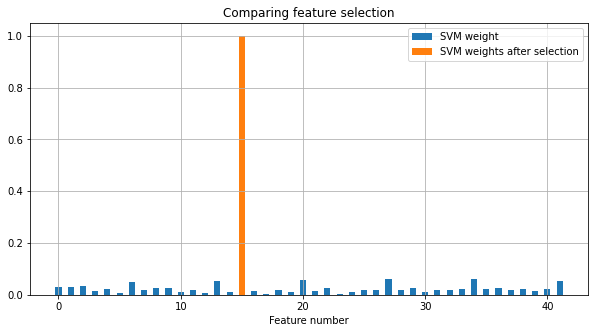

caracteristicas:  2
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.007858777727101085


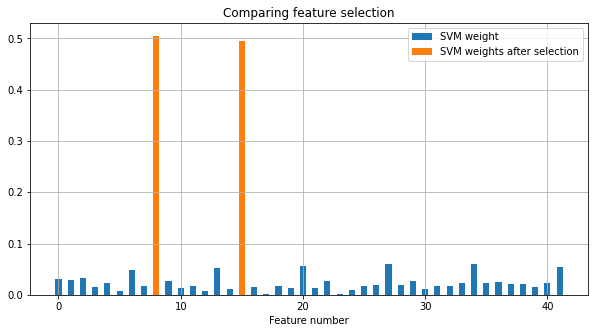

caracteristicas:  3
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.005017146697438468


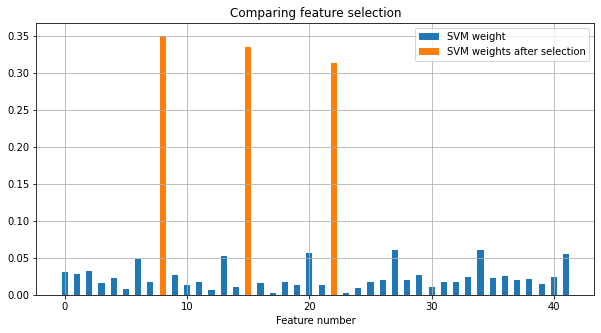

caracteristicas:  4
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.038711853383624595


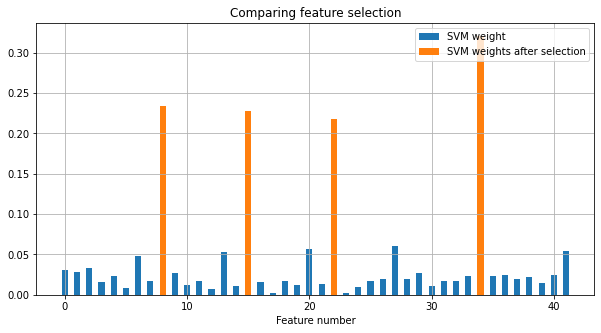

caracteristicas:  5
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11484151330586267


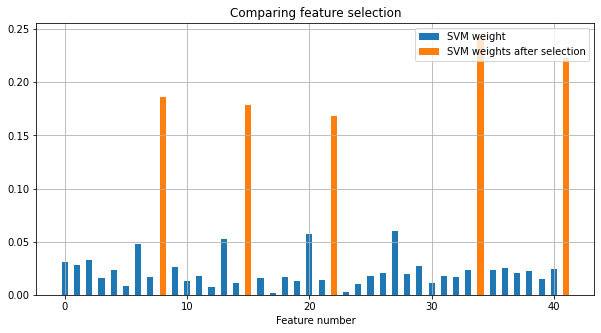

caracteristicas:  6
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.10411475338176324


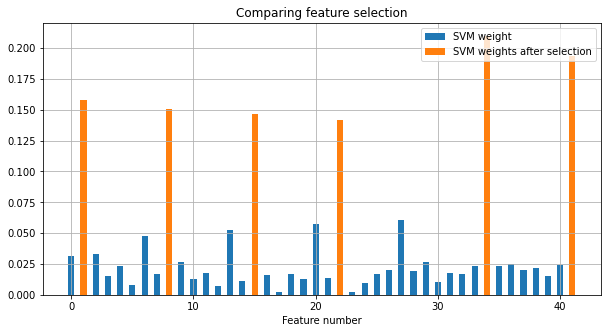

caracteristicas:  7
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.128511928299486


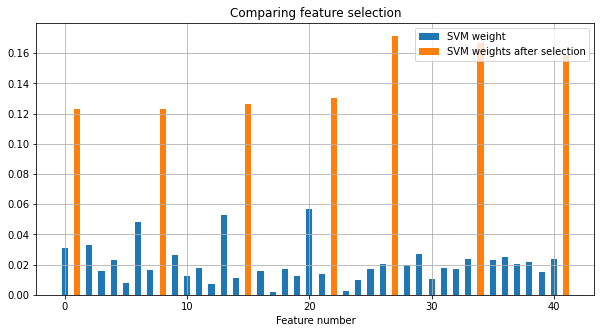

caracteristicas:  8
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11308088753679035


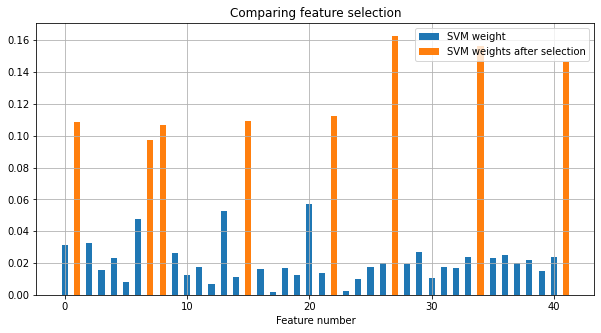

caracteristicas:  9
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.09777743983843834


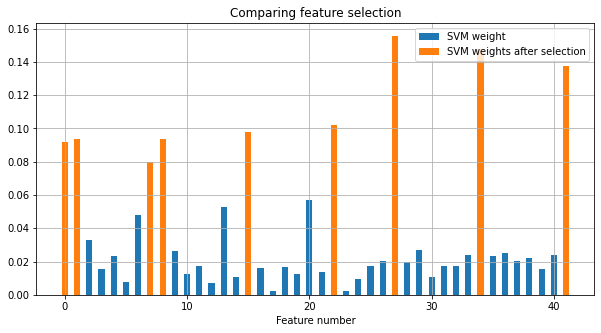

caracteristicas:  10
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.08703339460019532


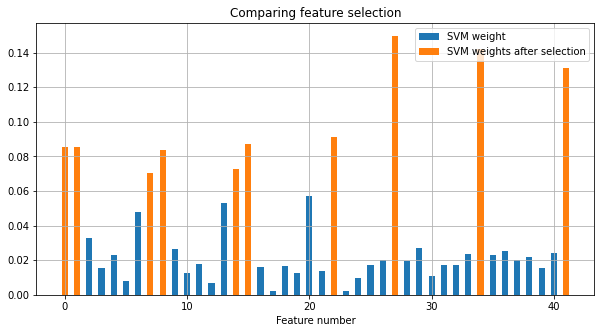

caracteristicas:  11
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.08318969613763838


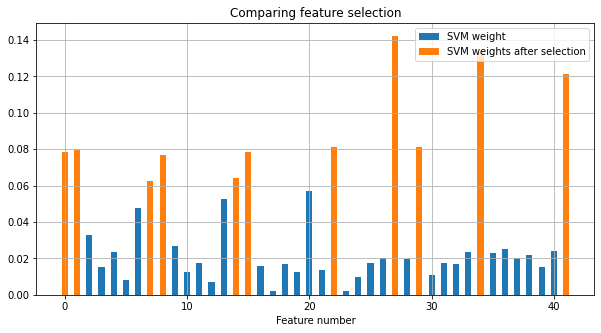

caracteristicas:  12
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.07618459397936972


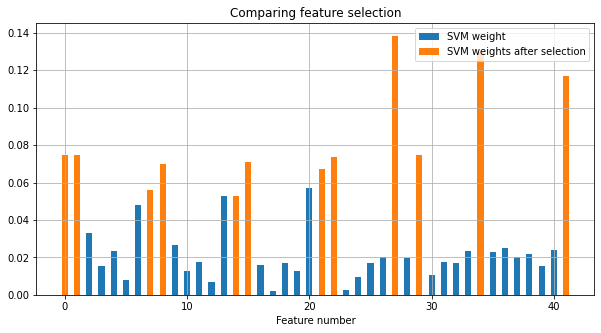

caracteristicas:  13
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.08450727854559426


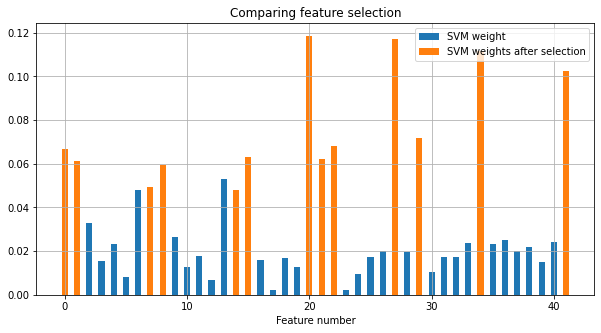

caracteristicas:  14
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.07699130622369332


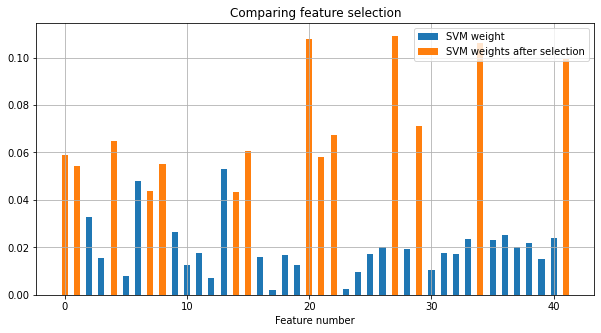

caracteristicas:  15
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.0801726337380364


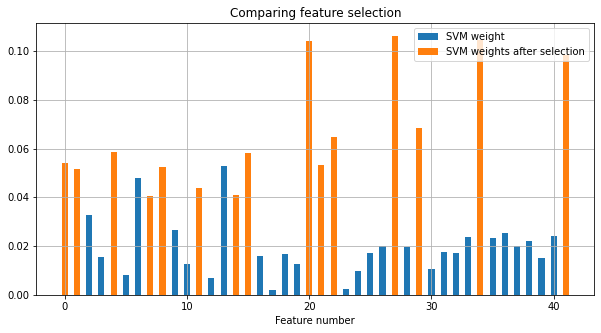

caracteristicas:  16
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.07464882206549017


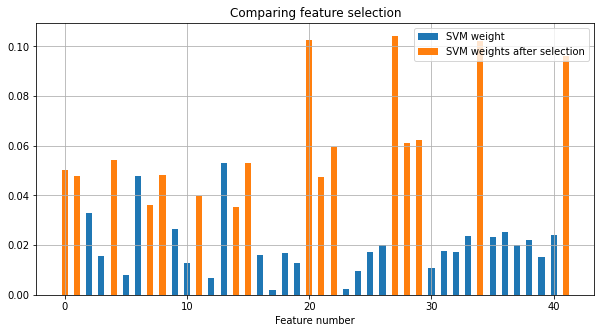

caracteristicas:  17
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.0762019861946448


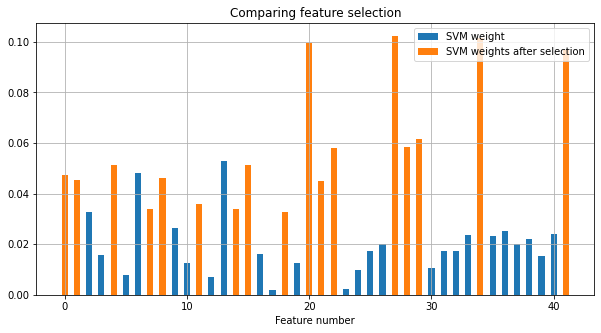

caracteristicas:  18
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.0848718736050611


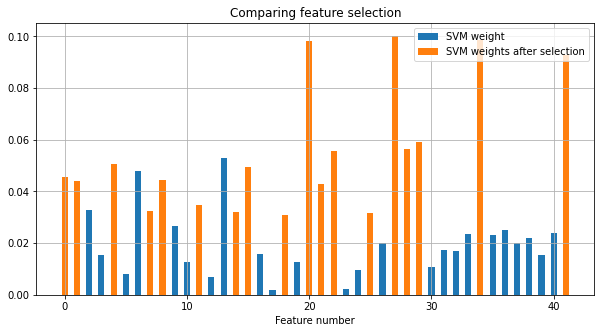

caracteristicas:  19
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.09304096912295146


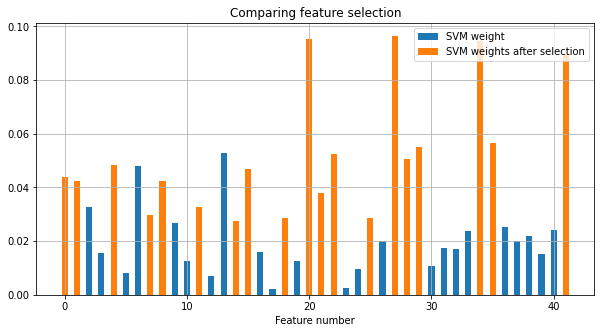

caracteristicas:  20
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.10544778265822918


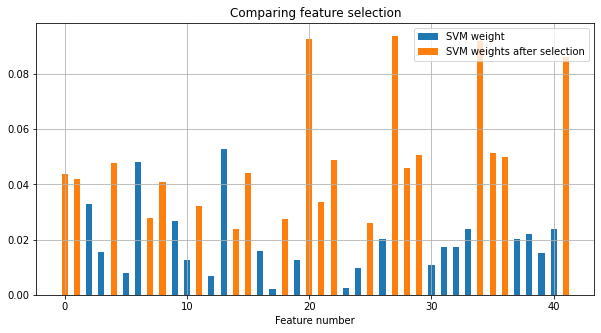

caracteristicas:  21
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.10381761959145286


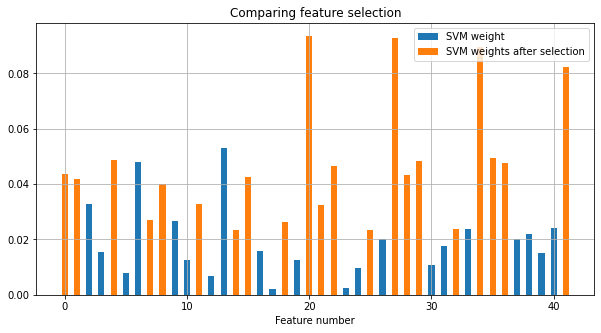

caracteristicas:  22
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.10586183484112066


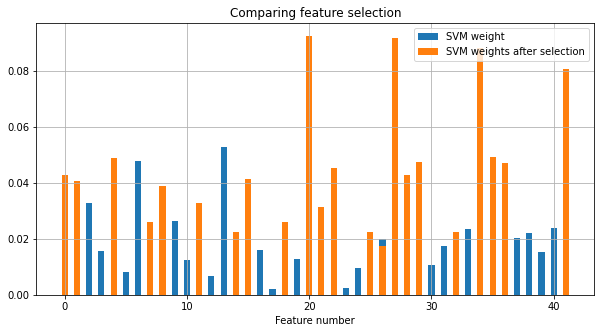

caracteristicas:  23
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11699262413146871


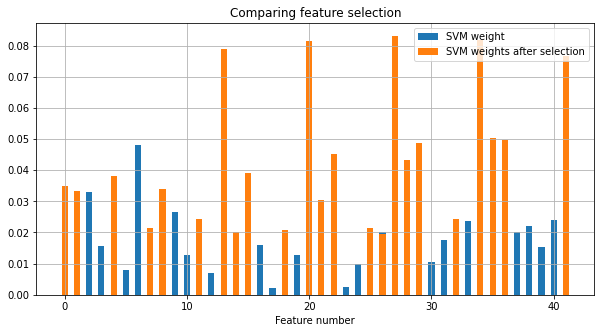

caracteristicas:  24
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11881703607498917


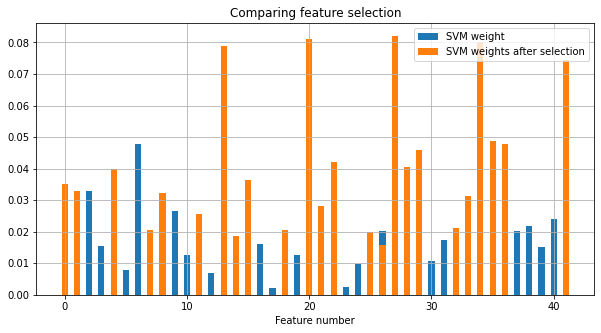

caracteristicas:  25
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11884731831001849


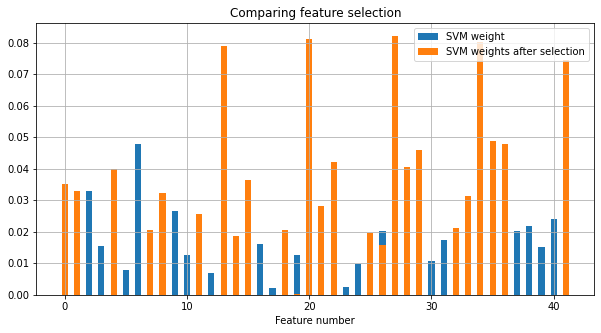

caracteristicas:  26
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11775995930034622


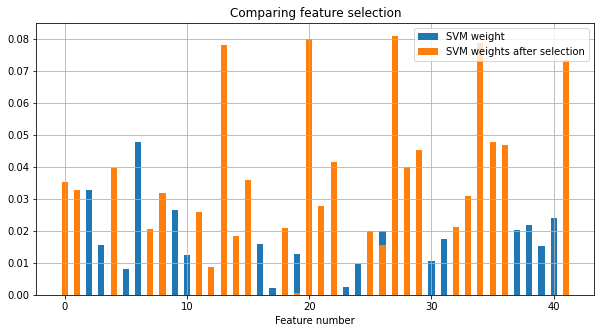

caracteristicas:  27
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11603408750335453


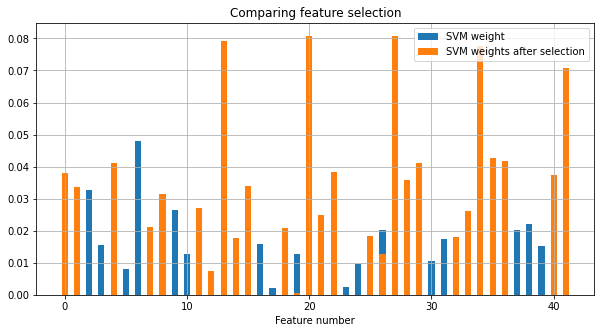

caracteristicas:  28
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11340881303071315


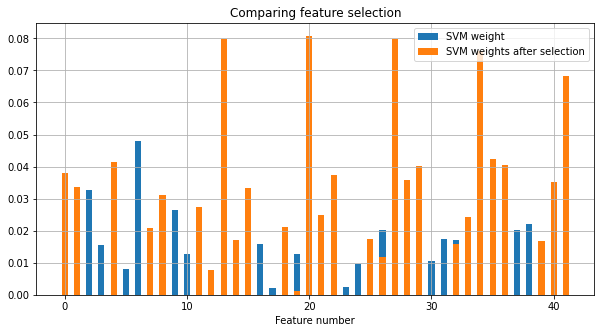

caracteristicas:  29
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11332563011201513


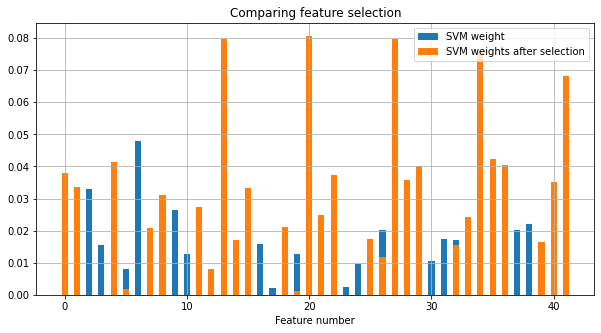

caracteristicas:  30
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11042831120292895


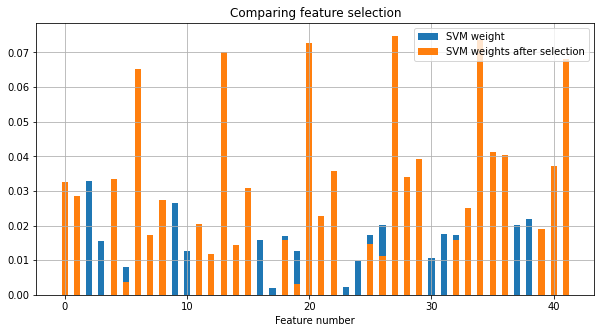

caracteristicas:  31
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11022071363138775


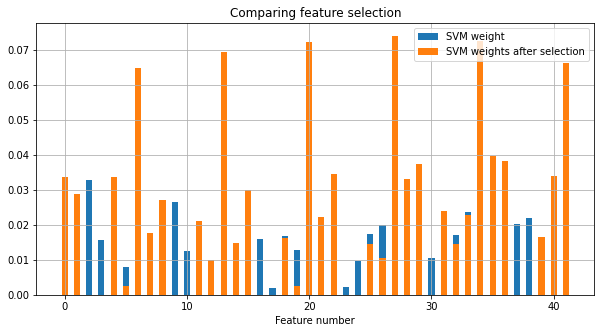

caracteristicas:  32
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.12525677124577106


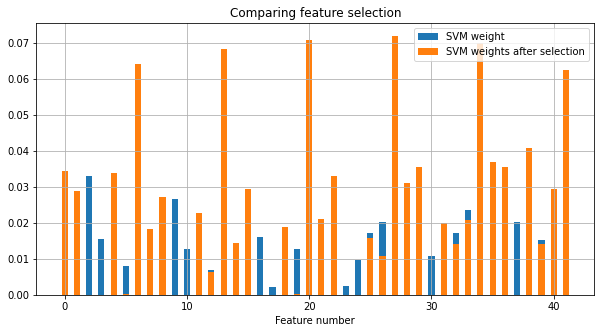

caracteristicas:  33
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.12278532947954068


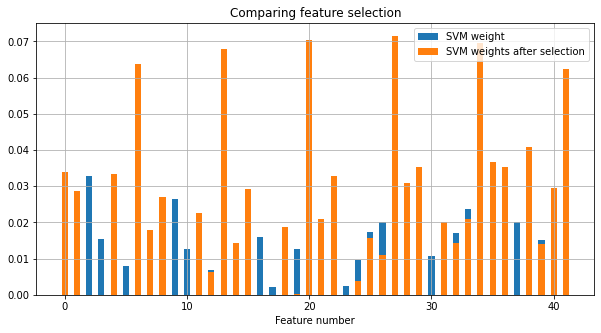

caracteristicas:  34
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11831639545854689


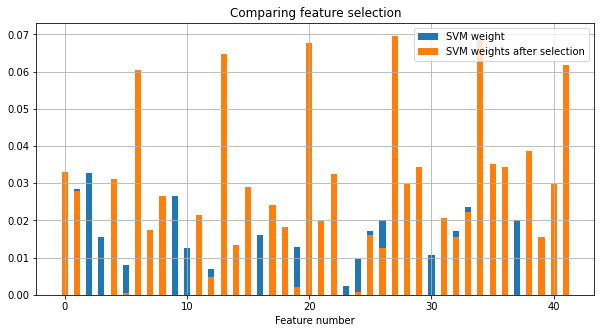

caracteristicas:  35
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.1157581172920168


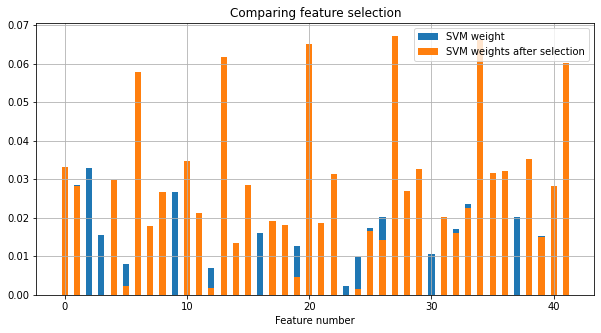

caracteristicas:  36
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11110543404418238


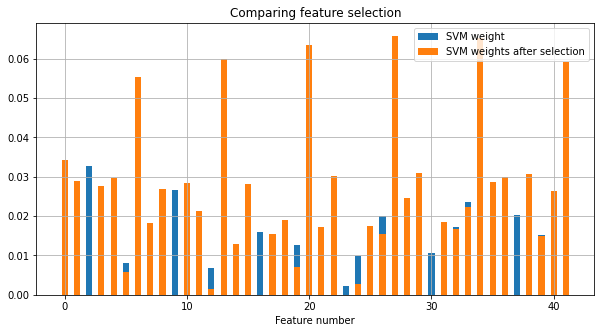

caracteristicas:  37
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.1110436733194653


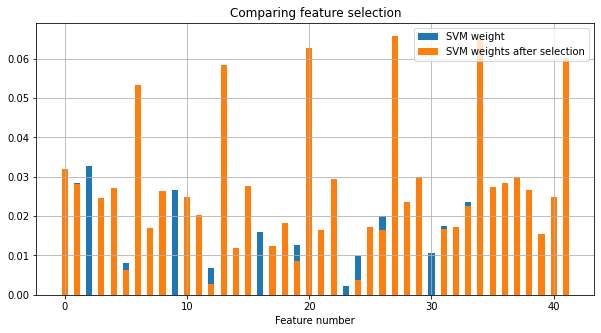

caracteristicas:  38
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11302563236061891


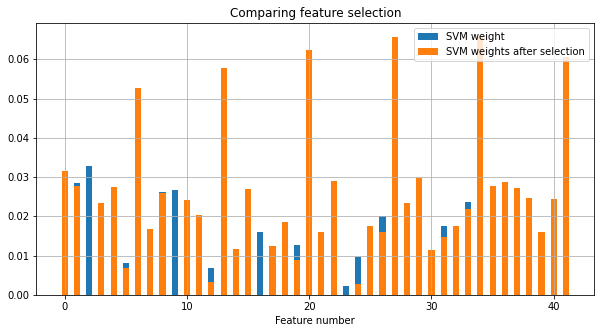

caracteristicas:  39
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.11220289381849002


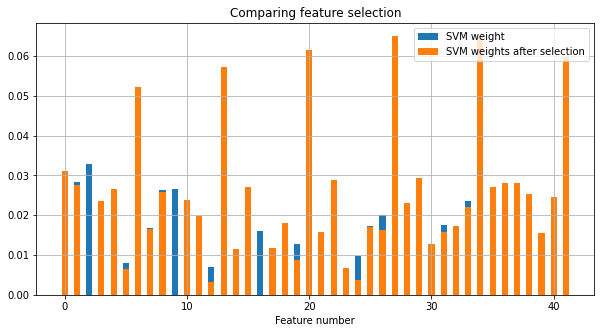

caracteristicas:  40
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.10281840313909307


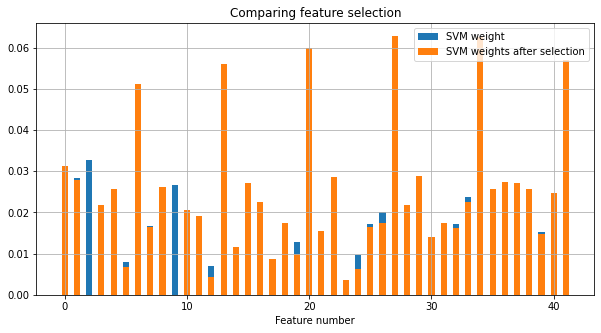

caracteristicas:  41
Classification accuracy without selecting features: -0.10024019008352436
Classification accuracy after univariate feature selection: -0.09536561717016201


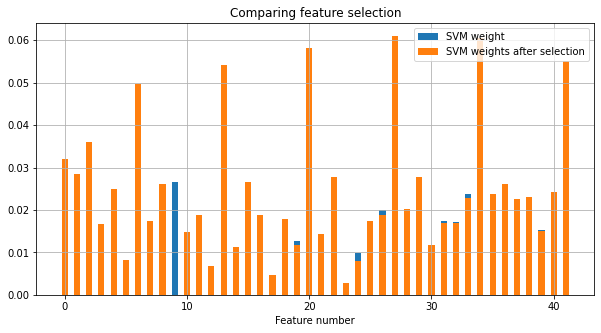

In [20]:
#Definir el numero de variables que seran usadas en la seleccion de cacteristicas
n_var = XS_REAL.shape[1]     # NUMERO DE VARIABLES
print(n_var)
score_maquinas=[]
for i in range(1,n_var-1):
    print("caracteristicas: ",i)
    val=seleccion(f_regression,i) #valor F anova
    score_maquinas.append([feature_names[i], abs(val)])

    
#     #print(len(score_maquinas))

#     plt.figure(1,figsize=(20,10))
#     plt.clf()
#     X_indices = np.arange(len(score_maquinas))
#     print(score_maquinas[i][1])
#     plt.bar(X_indices , score_maquinas[i][1], width=.5, label='score') #- .45
#     plt.title("'rendimiento maquinas'")
#     plt.xlabel('Feature number')
#     #plt.yticks(())
#     plt.grid()
#     plt.axis('tight')
#     plt.legend(loc='upper right')

#     plt.savefig(nombre_g, dpi=300)
#     plt.show()     


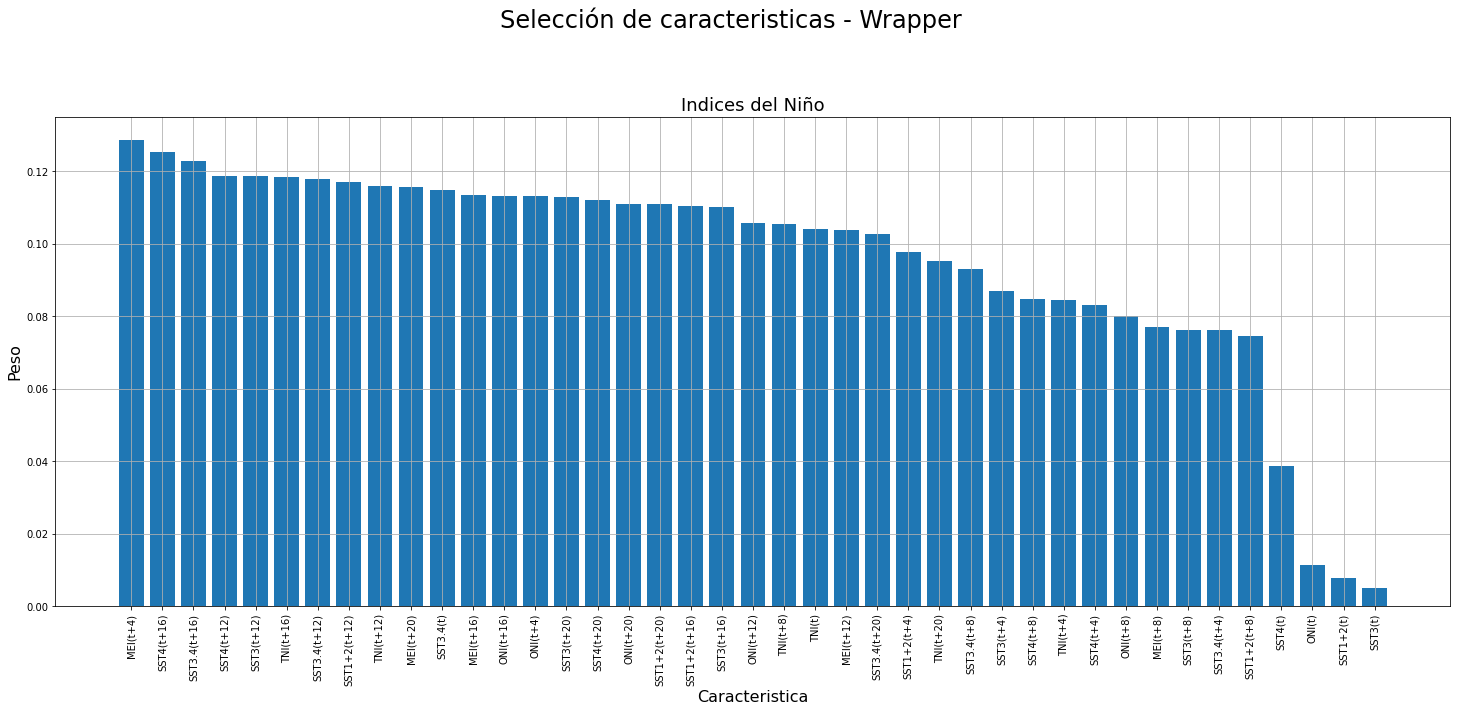

41


[]

In [21]:
score_maquinas_orden = sorted(score_maquinas, key = lambda x: x[1], reverse=True)
df_score_maquinas_orden = pd.DataFrame(score_maquinas_orden)
df_score_maquinas_orden

df_score_maquinas_orden.to_csv(PATH_O + 'caracteristicas_Wrapper_ordenado.csv', index=True)

x_g = df_score_maquinas_orden[0]
y_g = df_score_maquinas_orden[1]

plt.figure(1,figsize=(25,9))

plt.y_pos = np.arange(len(df_score_maquinas_orden))
plt.bar(x_g, y_g)
X_indices = np.arange(len(df_score_maquinas_orden))
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Wrapper', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.xticks(X_indices, x_g, rotation='vertical', fontsize = 10)
# ax.set_xscale('log')
#ax.invert_yaxis()
plt.grid()
plt.savefig(PATH_O + 'Wrapper_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()

#score_maquinas_orden


caracteristicas_select=[]
print(len(score_maquinas_orden))
for i in range(0, len(score_maquinas_orden)):
    if score_maquinas_orden[i][1]>4:
        caracteristicas_select.append(score_maquinas_orden[i][0])

caracteristicas_select

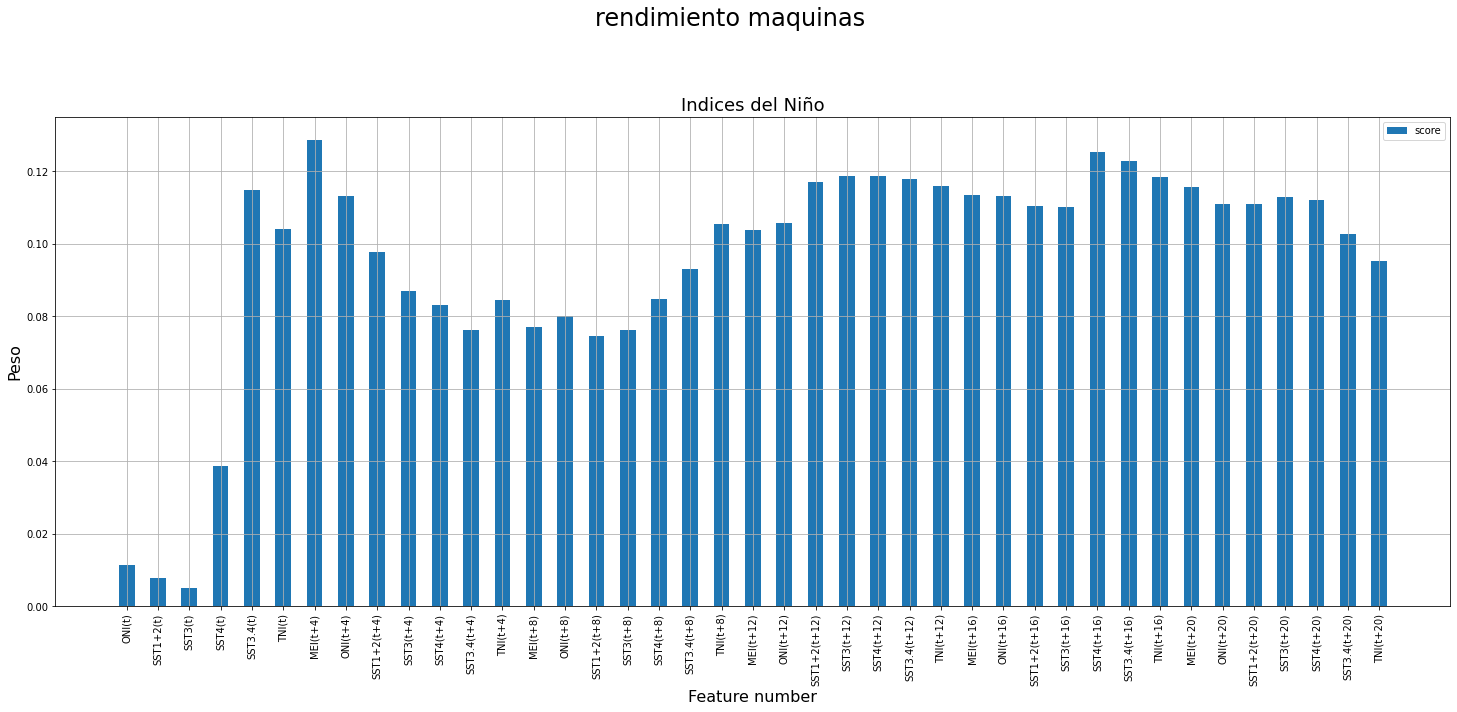

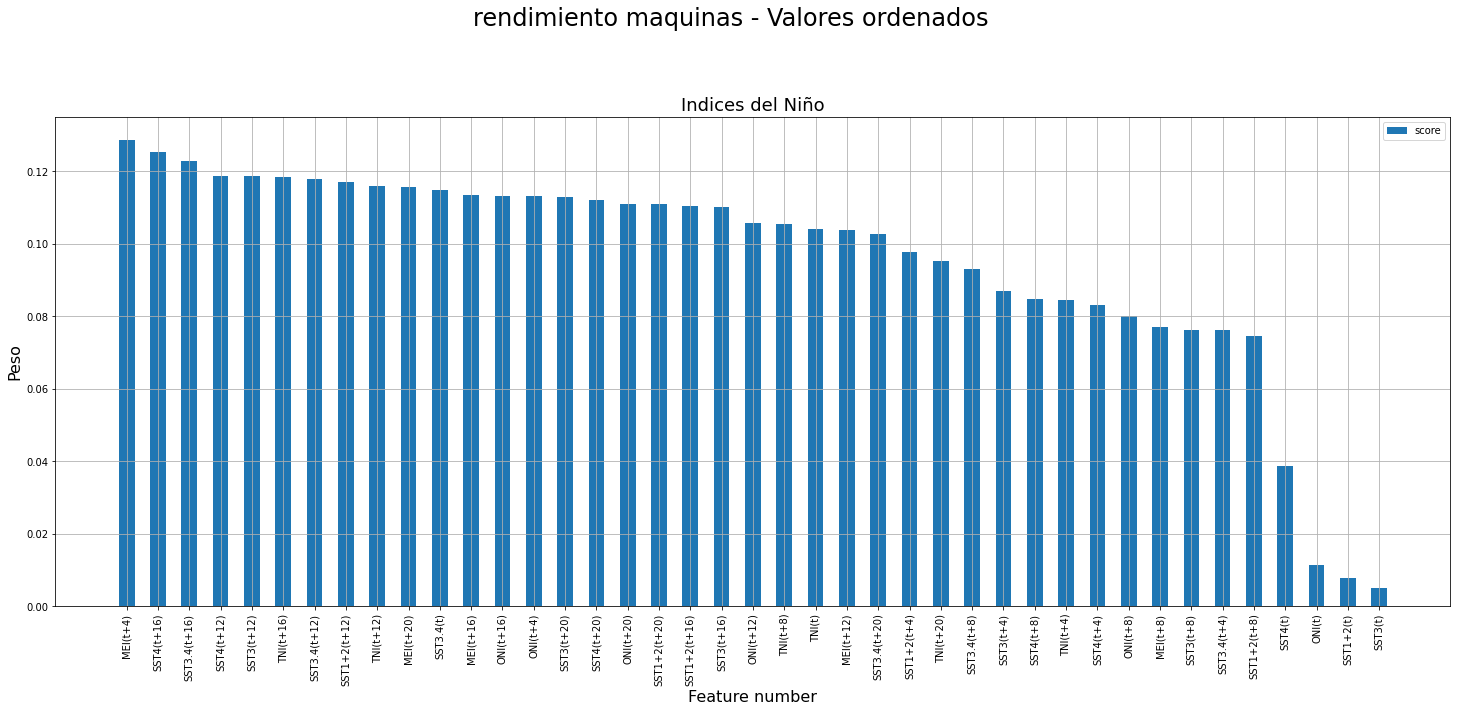

In [22]:
#print(len(score_maquinas))

df_score_maquinas = pd.DataFrame(score_maquinas)

plt.figure(1,figsize=(25,9))
plt.clf()
X_indices = np.arange(len(score_maquinas))
features = df_score_maquinas[0]
plt.bar(X_indices , df_score_maquinas[1], width=.5, label='score') #- .45
plt.xticks(X_indices, features, rotation='vertical', fontsize = 10)
plt.suptitle('rendimiento maquinas', y=1.05, fontsize = 24)
plt.title(title_string, fontsize=18)
plt.xlabel('Feature number', fontsize = 16)
plt.ylabel('Peso', fontsize = 16)
#plt.yticks(())
plt.grid()
plt.axis('tight')
plt.legend(loc='upper right')

plt.savefig(PATH_O + 'Wrapper_No_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show() 

# GRAFICAR LOS DATOS OBTENIDOS EN FORMA ORDENADA


plt.figure(1,figsize=(25,9))
plt.clf()
X_indices = np.arange(len(df_score_maquinas_orden[0]))
features = df_score_maquinas_orden[0]
plt.bar(X_indices , df_score_maquinas_orden[1], width=.5, label='score') #- .45
plt.xticks(X_indices, features, rotation='vertical', fontsize = 10)
plt.suptitle('rendimiento maquinas - Valores ordenados', y=1.05, fontsize = 24)
plt.title(title_string, fontsize=18)
plt.xlabel('Feature number', fontsize = 16)
plt.ylabel('Peso', fontsize = 16)
#plt.yticks(())
plt.grid()
plt.axis('tight')
plt.legend(loc='upper right')

plt.savefig(PATH_O + 'Wrapper_ordenado_01.jpg', dpi=100, bbox_inches='tight')
plt.show() 

In [23]:
## mutual_info_regression

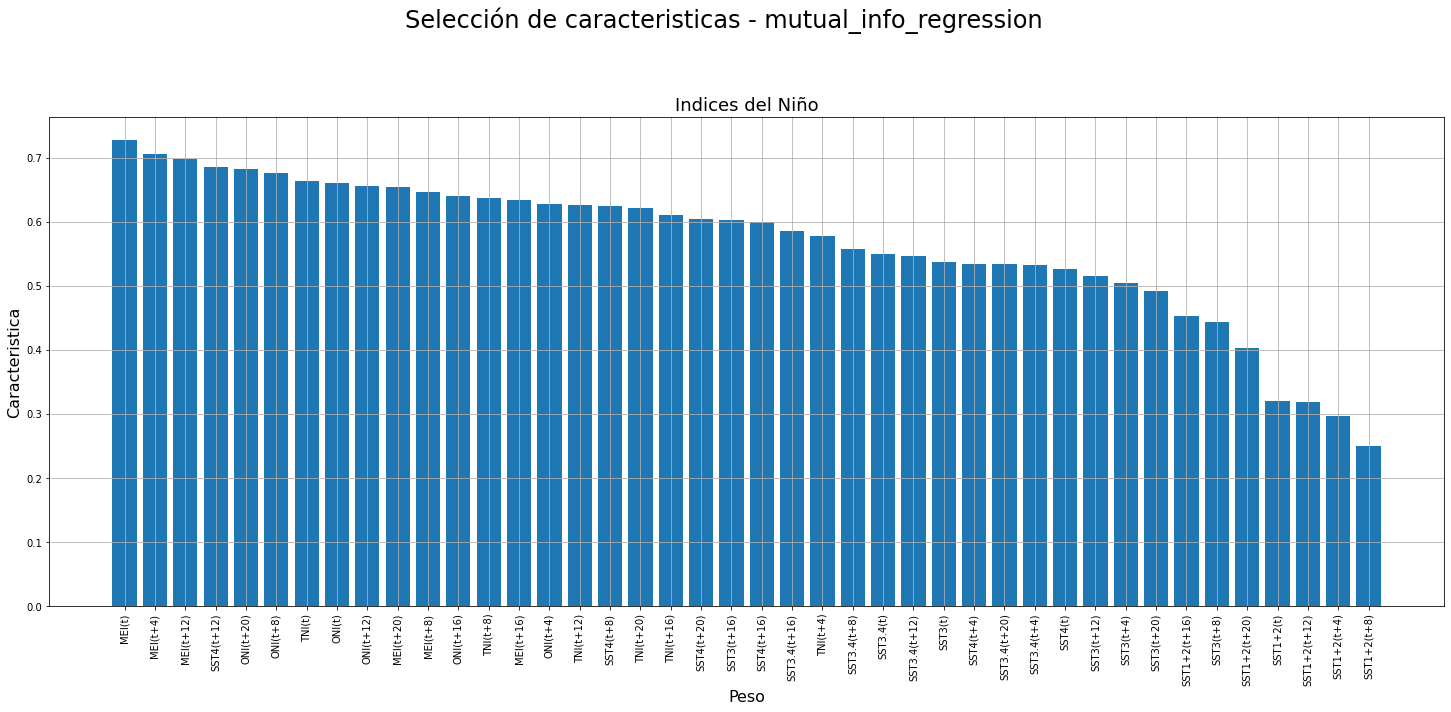

['MEI(t)',
 'MEI(t+4)',
 'MEI(t+12)',
 'SST4(t+12)',
 'ONI(t+20)',
 'ONI(t+8)',
 'TNI(t)',
 'ONI(t)',
 'ONI(t+12)',
 'MEI(t+20)',
 'MEI(t+8)',
 'ONI(t+16)',
 'TNI(t+8)',
 'MEI(t+16)',
 'ONI(t+4)',
 'TNI(t+12)',
 'SST4(t+8)',
 'TNI(t+20)',
 'TNI(t+16)',
 'SST4(t+20)',
 'SST3(t+16)',
 'SST4(t+16)',
 'SST3.4(t+16)',
 'TNI(t+4)',
 'SST3.4(t+8)',
 'SST3.4(t)',
 'SST3.4(t+12)',
 'SST3(t)',
 'SST4(t+4)',
 'SST3.4(t+20)',
 'SST3.4(t+4)',
 'SST4(t)',
 'SST3(t+12)',
 'SST3(t+4)']

In [24]:
n=n_var-1 #numero caracteristicas
# Feature extraction
test = SelectKBest(score_func = mutual_info_regression, k=n) #cambiar score_func y k <- mejor segun grafica arriba
fit = test.fit(x, y)

# Summarize scores
np.set_printoptions(precision=3)
scores = test.scores_
mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature,score in zip(mask, feature_names,scores):
    if bool:
        new_features.append([feature,score])

CR1 = sorted(new_features, key = lambda x: x[1], reverse=True)
df_CR1 = pd.DataFrame(CR1)        
#print(f'{n} caracteristicas: ',CR)

df_CR1

#features = fit.transform(x)
# Summarize selected features
#print(features[0:5,:])





plt.figure(1,figsize=(25,9))
#ax = plt.gca()
plt.y_pos = np.arange(len(df_CR1))
X_indices = np.arange(len(df_CR1[0]))
features = df_CR1[0]
score_feature = df_CR1[1]
plt.bar(features, score_feature)
plt.xticks(X_indices, features, rotation='vertical', fontsize = 10)
plt.xlabel('Peso', fontsize = 16)
plt.ylabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - mutual_info_regression', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
# plt.xscale('log')
# plt.invert_yaxis()
plt.grid()
plt.savefig(PATH_O + 'Mutual_info_regression_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()
df_CR1 
AAA = df_CR1

for i in range (0, len(CR1)):
    if CR1[i][1]>0.5:
        caracteristicas_select.append(CR1[i][0])
caracteristicas_select

In [25]:
df_CR1.to_csv(PATH_O + 'caracteristicas_mutual_regresion.csv', index=True)

In [26]:
## f_classif

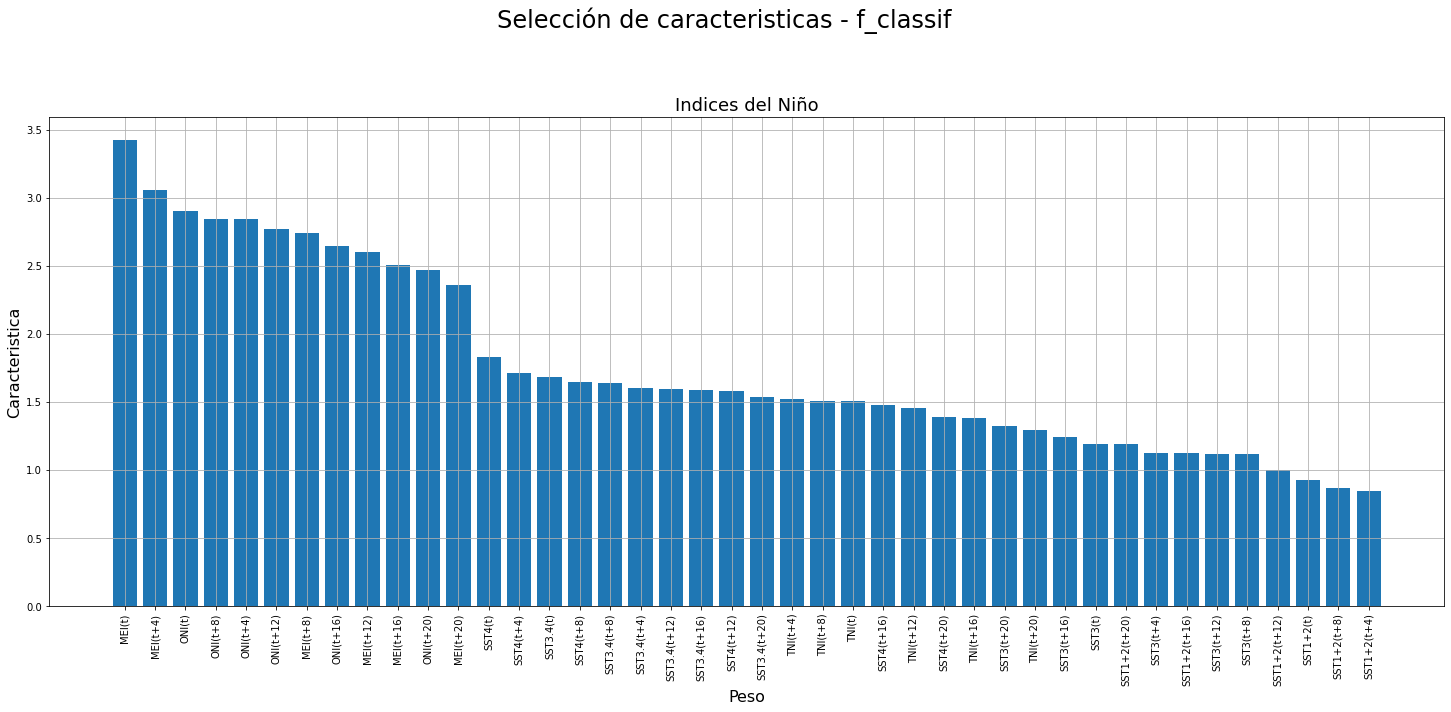

['MEI(t)',
 'MEI(t+4)',
 'MEI(t+12)',
 'SST4(t+12)',
 'ONI(t+20)',
 'ONI(t+8)',
 'TNI(t)',
 'ONI(t)',
 'ONI(t+12)',
 'MEI(t+20)',
 'MEI(t+8)',
 'ONI(t+16)',
 'TNI(t+8)',
 'MEI(t+16)',
 'ONI(t+4)',
 'TNI(t+12)',
 'SST4(t+8)',
 'TNI(t+20)',
 'TNI(t+16)',
 'SST4(t+20)',
 'SST3(t+16)',
 'SST4(t+16)',
 'SST3.4(t+16)',
 'TNI(t+4)',
 'SST3.4(t+8)',
 'SST3.4(t)',
 'SST3.4(t+12)',
 'SST3(t)',
 'SST4(t+4)',
 'SST3.4(t+20)',
 'SST3.4(t+4)',
 'SST4(t)',
 'SST3(t+12)',
 'SST3(t+4)',
 'MEI(t)',
 'MEI(t+4)',
 'ONI(t)',
 'ONI(t+8)',
 'ONI(t+4)',
 'ONI(t+12)',
 'MEI(t+8)',
 'ONI(t+16)',
 'MEI(t+12)',
 'MEI(t+16)',
 'ONI(t+20)',
 'MEI(t+20)',
 'SST4(t)',
 'SST4(t+4)',
 'SST3.4(t)',
 'SST4(t+8)',
 'SST3.4(t+8)',
 'SST3.4(t+4)',
 'SST3.4(t+12)',
 'SST3.4(t+16)',
 'SST4(t+12)',
 'SST3.4(t+20)',
 'TNI(t+4)',
 'TNI(t+8)',
 'TNI(t)']

In [27]:
n=n_var-1 #numero caracteristicas
# Feature extraction
test = SelectKBest(score_func = f_classif, k=n) #cambiar score_func y k <- mejor segun grafica arriba
fit = test.fit(x, y)

# Summarize scores
np.set_printoptions(precision=3)
scores = test.scores_
mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature,score in zip(mask, feature_names,scores):
    if bool:
        new_features.append([feature,score])

        
CR2 = sorted(new_features, key = lambda x: x[1], reverse=True)
df_CR2 = pd.DataFrame(CR2)        
#print(f'{n} caracteristicas: ',CR)
df_CR2

#print(f'{n} caracteristicas: ',sorted(new_features, key = lambda x: x[1], reverse=True))




plt.figure(1,figsize=(25,9))
#ax = plt.gca()
plt.y_pos = np.arange(len(df_CR2))
X_indices = np.arange(len(df_CR2[0]))
features = df_CR2[0]
score_feature = df_CR2[1]
plt.bar(features, score_feature)
plt.xticks(X_indices, features, rotation='vertical', fontsize = 10)
plt.xlabel('Peso', fontsize = 16)
plt.ylabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - f_classif', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
#plt.xscale('log')
#plt.invert_yaxis()
plt.grid()
plt.savefig(PATH_O + 'f_classif_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()
df_CR2 
BBB = df_CR2 


for i in range (0, len(CR2)):
    if CR2[i][1]>1.5:
        caracteristicas_select.append(CR2[i][0])
caracteristicas_select

In [28]:
df_CR2.to_csv(PATH_O + 'caracteristicas_peso_f_clasif.csv', index=True)

In [29]:
## f_regression

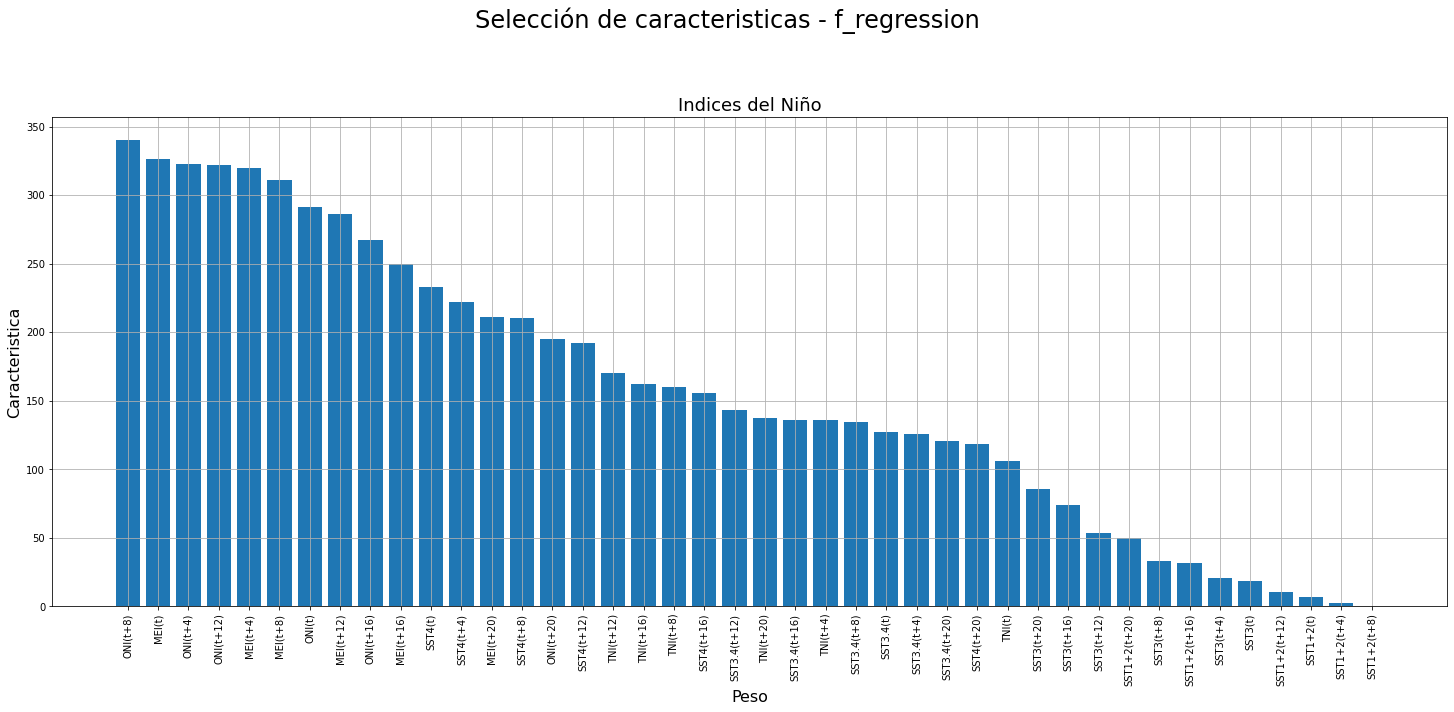

98
39


['MEI(t)',
 'MEI(t+12)',
 'MEI(t+16)',
 'MEI(t+20)',
 'MEI(t+4)',
 'MEI(t+8)',
 'ONI(t)',
 'ONI(t+12)',
 'ONI(t+16)',
 'ONI(t+20)',
 'ONI(t+4)',
 'ONI(t+8)',
 'SST1+2(t+12)',
 'SST1+2(t+16)',
 'SST1+2(t+20)',
 'SST3(t)',
 'SST3(t+12)',
 'SST3(t+16)',
 'SST3(t+20)',
 'SST3(t+4)',
 'SST3(t+8)',
 'SST3.4(t)',
 'SST3.4(t+12)',
 'SST3.4(t+16)',
 'SST3.4(t+20)',
 'SST3.4(t+4)',
 'SST3.4(t+8)',
 'SST4(t)',
 'SST4(t+12)',
 'SST4(t+16)',
 'SST4(t+20)',
 'SST4(t+4)',
 'SST4(t+8)',
 'TNI(t)',
 'TNI(t+12)',
 'TNI(t+16)',
 'TNI(t+20)',
 'TNI(t+4)',
 'TNI(t+8)']

In [30]:
n=n_var-1 #numero caracteristicas
# Feature extraction
test = SelectKBest(score_func = f_regression, k=n) #cambiar score_func y k <- mejor segun grafica arriba
fit = test.fit(x, y)

# Summarize scores
np.set_printoptions(precision=3)
scores = test.scores_
mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature,score in zip(mask, feature_names,scores):
    if bool:
        new_features.append([feature,score])

CR3 = sorted(new_features, key = lambda x: x[1], reverse=True)
df_CR3 = pd.DataFrame(CR3)        
#print(f'{n} caracteristicas: ',CR)
        
#print(f'{n} caracteristicas: ',sorted(new_features, key = lambda x: x[1], reverse=True))




plt.figure(1,figsize=(25,9))
X_indices = np.arange(len(df_CR3[0]))
#ax = plt.gca()
plt.y_pos = np.arange(len(df_CR3))
features = df_CR3[0]
score_feature = df_CR3[1]
plt.bar(features, score_feature)
plt.xlabel('Peso', fontsize = 16)
plt.ylabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - f_regression', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.xticks(X_indices, features, rotation='vertical', fontsize = 10)
plt.grid()
#ax.set_xscale('log')
#ax.invert_yaxis()
plt.savefig(PATH_O + 'f_regression_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()
df_CR3 
CCC = df_CR3


for i in range (0, len(CR3)):
    if CR3[i][1]>10.0:
        caracteristicas_select.append(CR3[i][0])

print(len(caracteristicas_select))
caracteristicas_select1 = set(caracteristicas_select)
print(len(caracteristicas_select1))


caracteristicas_select2 = sorted(list(caracteristicas_select1))

caracteristicas_select2

In [31]:
df_CR2.to_csv(PATH_O + 'caracteristicas_f_regression_ordenado.csv', index=True)

In [32]:
df_CR1.sort_values(0, inplace=True)
AAA1 = df_CR1

df_CR2.sort_values(0, inplace=True)
BBB1 = df_CR2

df_CR3.sort_values(0, inplace=True)
CCC1 = df_CR3

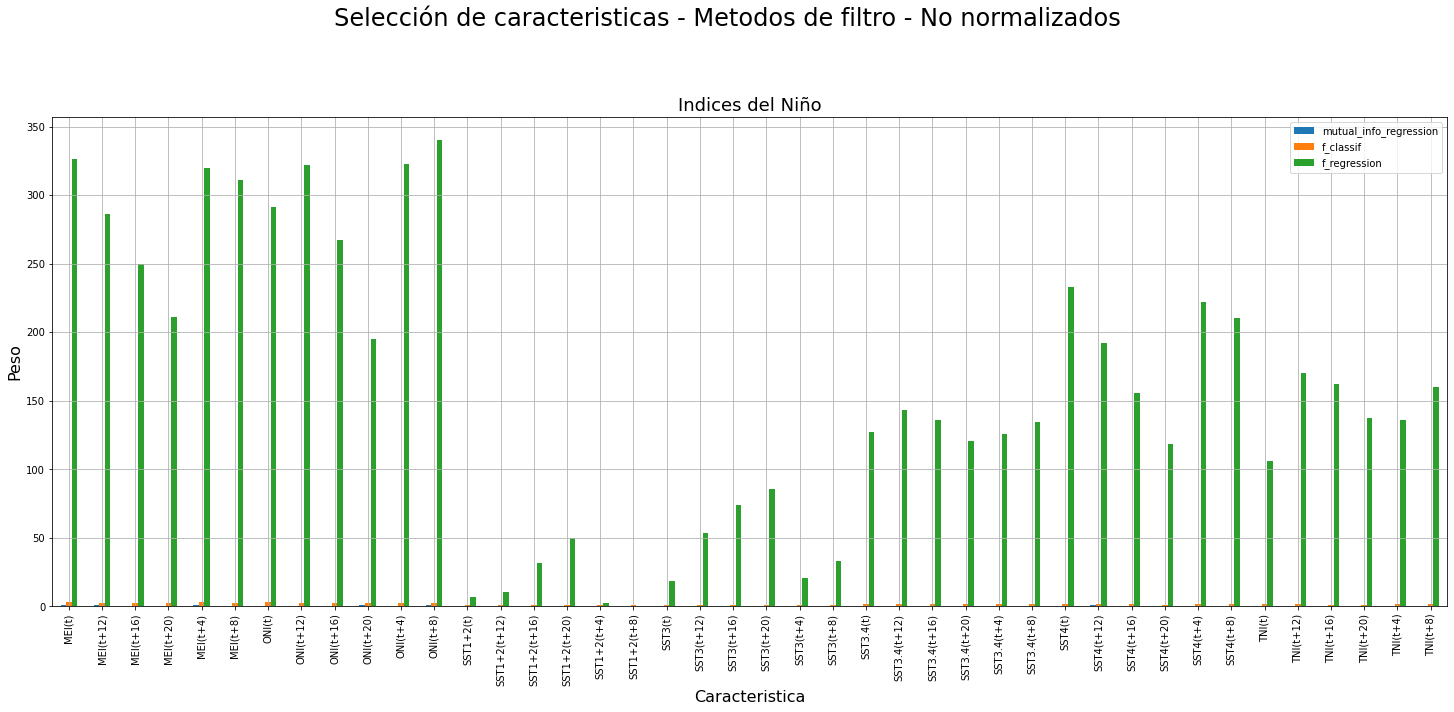

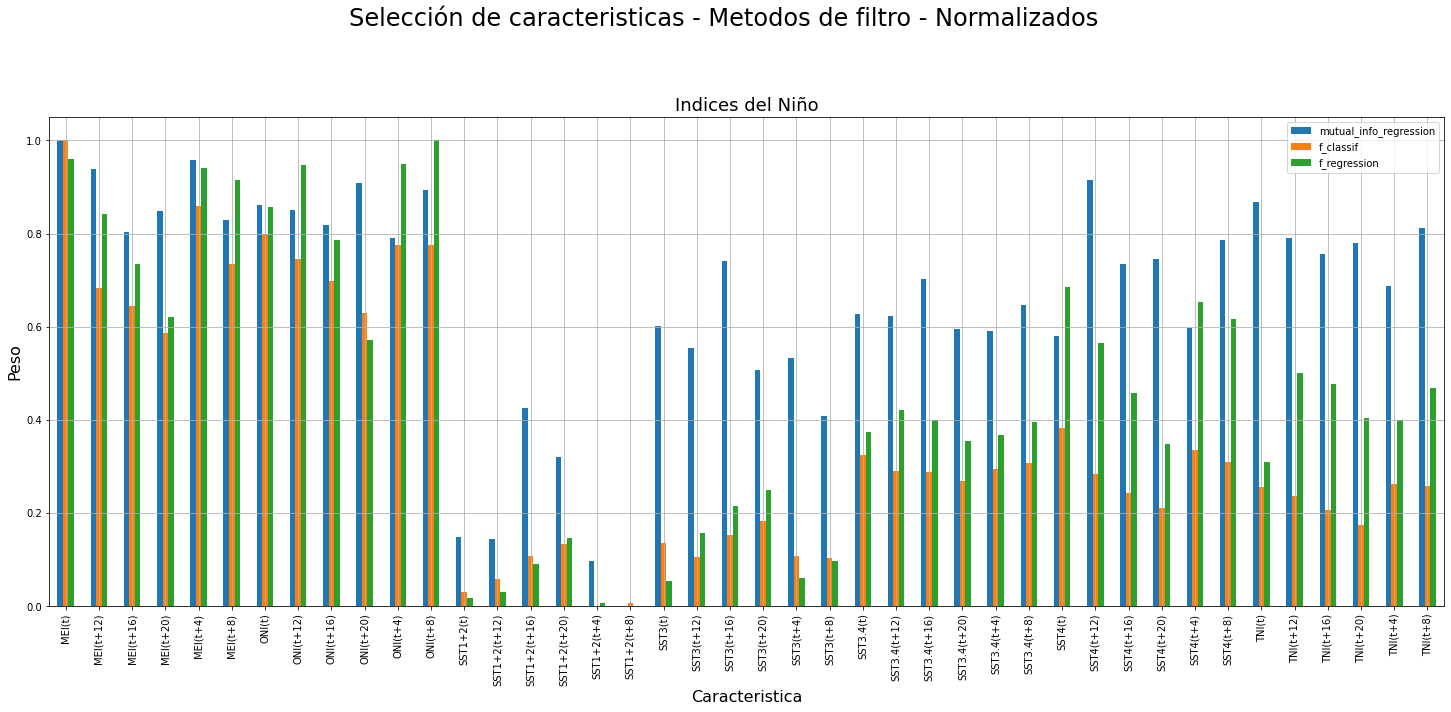

In [33]:
LLL1 = np.reshape(AAA1.values[:,0],(len(AAA1),1))
AAA1_V = np.reshape(AAA1.values[:,1],(len(AAA1),1))
AAA1_S = escalador(AAA1_V, np.amin(AAA1_V), np.amax(AAA1_V))
BBB1_V = np.reshape(BBB1.values[:,1],(len(AAA1),1))
BBB1_S = escalador(BBB1_V, np.amin(BBB1_V), np.amax(BBB1_V))
CCC1_V = np.reshape(CCC1.values[:,1],(len(AAA1),1))
CCC1_S = escalador(CCC1_V, np.amin(CCC1_V), np.amax(CCC1_V))
carac = np.append(LLL1,AAA1_V,axis=1)
carac = np.append(carac,BBB1_V,axis=1)
carac = np.append(carac,CCC1_V,axis=1)
Escal = AAA1_S + BBB1_S + CCC1_S

carac

Escalados = np.append(LLL1,Escal,axis=1)
Escalados

C0 = list(carac[:,0])
C1 = list(carac[:,1])
C2 = list(carac[:,2])
C3 = list(carac[:,3])



Caracteristicas_sin_escala = pd.DataFrame({'Caracteristica': C0, 'mutual_info_regression' : C1, 'f_classif' : C2, 'f_regression': C3})
Caracteristicas_sin_escala.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caracteristicas_sin_escala))
plt.xticks(X_indices, Caracteristicas_sin_escala['Caracteristica'], rotation='vertical', fontsize = 10)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Metodos de filtro - No normalizados', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-NO-Normalizados.jpg', dpi=100, bbox_inches='tight')
plt.show()

carac_s = np.append(LLL1,AAA1_S,axis=1)
carac_s = np.append(carac_s,BBB1_S,axis=1)
carac_s = np.append(carac_s,CCC1_S,axis=1)
C0_S = list(carac_s[:,0])
C1_S = list(carac_s[:,1])
C2_S = list(carac_s[:,2])
C3_S = list(carac_s[:,3])

Caracteristicas_escalado = pd.DataFrame({'Caracteristica': C0_S, 'mutual_info_regression' : C1_S, 'f_classif' : C2_S, 'f_regression': C3_S})
Caracteristicas_escalado.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caracteristicas_escalado))
plt.xticks(X_indices, Caracteristicas_escalado['Caracteristica'], rotation='vertical', fontsize = 10)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Metodos de filtro - Normalizados', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Normalizados.jpg', dpi=100, bbox_inches='tight')
plt.show()
#pd.concat([df_CR1,df_CR2,df_CR3], ignore_index=True, axis=1)

# limite_caracteristica = np.array(([np.amin(caracteristicas_v[:,0])],[np.amax(caracteristicas_v[:,0])]))
# scaled_feature[:,i]=escalador(caracteristicas_v[:,i],limite_caracteristica[0][i],limite_caracteristica[1][i])

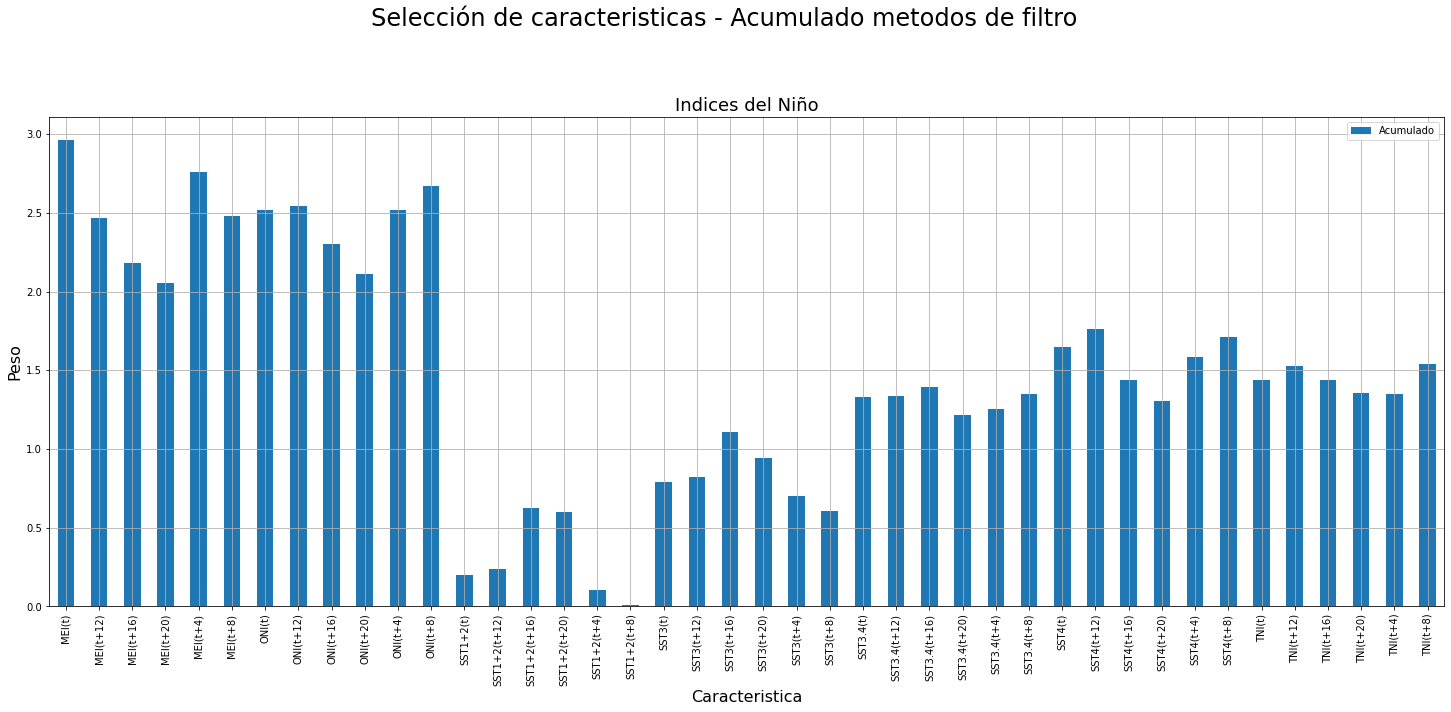

(38, 2)


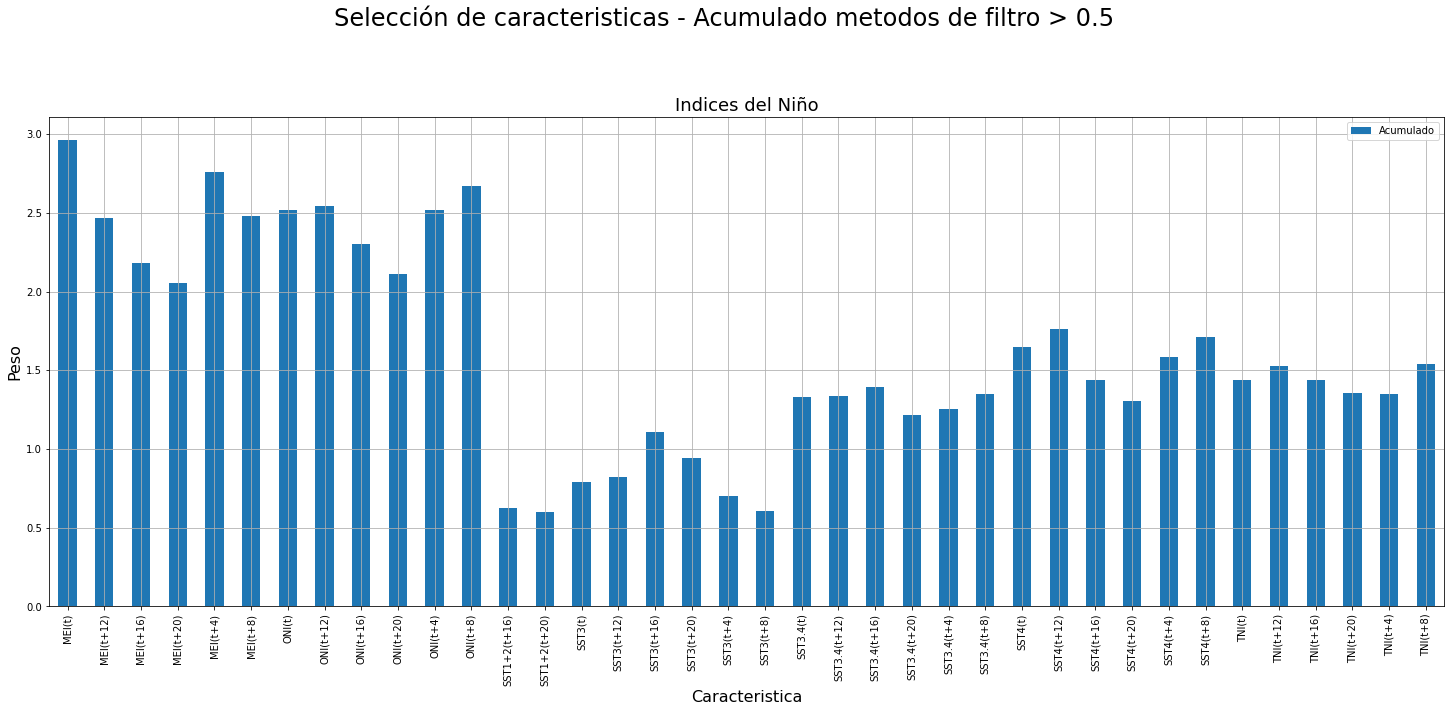

In [34]:
Escalados1 = list(Escalados[:,0])
Escalados2 = list(Escalados[:,1])
Caract_Escal = pd.DataFrame({'Caracteristica': Escalados1, 'Acumulado': Escalados2})
Caract_Escal

Caract_Escal.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caract_Escal))
plt.xticks(X_indices, Caract_Escal['Caracteristica'], rotation='vertical', fontsize = 10)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Acumulado metodos de filtro', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Acumulaos.jpg', dpi=100, bbox_inches='tight')
plt.show()

Caract_Escal_Filtado = Caract_Escal[Caract_Escal['Acumulado']>0.5]
print(Caract_Escal_Filtado.shape)

Caract_Escal_Filtado.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caract_Escal_Filtado))
plt.xticks(X_indices, Caract_Escal_Filtado['Caracteristica'], rotation='vertical', fontsize = 10)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Acumulado metodos de filtro > 0.5', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Acumulados_mas_05.jpg', dpi=100, bbox_inches='tight')
plt.show()
#Caract_Escal_Filtado

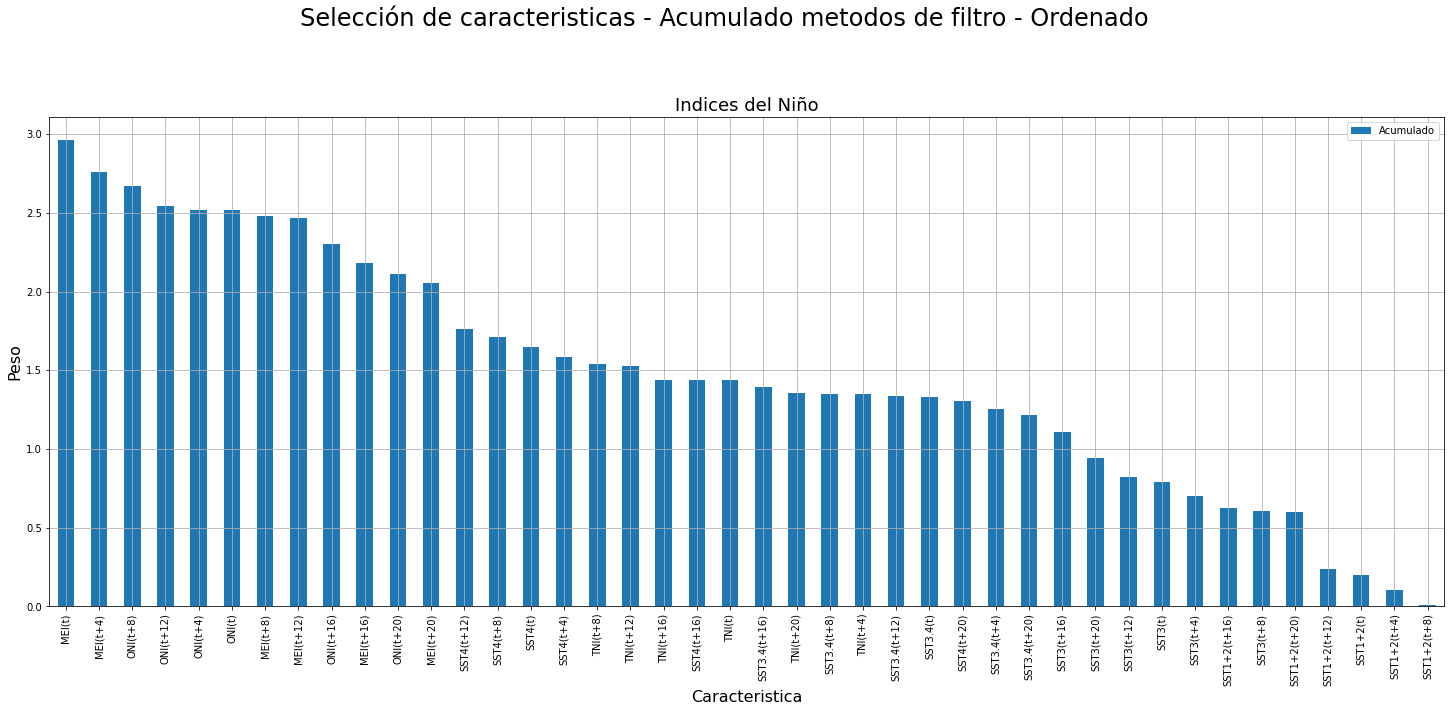

In [35]:

Caract_Escal_ORDEN = Caract_Escal.sort_values('Acumulado',ascending=False)


Caract_Escal_ORDEN.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caract_Escal_ORDEN))
plt.xticks(X_indices, Caract_Escal_ORDEN['Caracteristica'], rotation='vertical', fontsize = 10)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Acumulado metodos de filtro - Ordenado', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Acumulados_Ordenados.jpg', dpi=100, bbox_inches='tight')
plt.show()

Caract_Escal_ORDEN.to_csv(PATH_O + 'caracteristicas_filtro_acumulado_ordenado.csv', index=True)

In [36]:
# for i in range (0,len(Escalados)):
#     if (Escalados[[i],[1]]>=0.5):
#         print(Escalados[[i],[0]], "\t\t\t\t", Escalados[[i],[1]])

In [37]:
# Escalados = Escalados[Escalados[:,1].argsort(),]
# #print(Escalados)
# Escalados = Escalados[::-1]
# #print(Escalados)
# Caracteristicas_orden = list(Escalados[:,0])
# #print(Caracteristicas_orden)
# Data_orden = df[Caracteristicas_orden]
# Data_orden




In [38]:
# caracteristicas_s = pd.concat([df_CR1,df_CR2,df_CR3], ignore_index=True, axis=1)
# caracteristicas_s



In [39]:
# feature_name = caracteristicas_s[2]
# del caracteristicas_s[2]
# del caracteristicas_s[4]
# caracteristicas_s.set_index([0],inplace=True)
# caracteristicas_s=caracteristicas_s.rename(columns={1: "mutual_info_regression", 3: "f_classif", 5:"f_regression"})
# caracteristicas_s.to_csv(PATH_O + "caracterisitcas_ordenadas.csv", index=True)
# caracteristicas_s

In [40]:
# caracteristicas_v = caracteristicas_s.values

# #Crear una matriz con los limites para el esclalado de los datos
# limite_caracteristica = np.array(([np.amin(caracteristicas_v[:,0])],[np.amax(caracteristicas_v[:,0])]))

# for i in range(1,len(caracteristicas_v[1,:])):
#     limite_caracteristica = np.insert(limite_caracteristica, limite_caracteristica.shape[1], [np.amin(caracteristicas_v[:,i]), np.amax(caracteristicas_v[:,i])], axis=1)


# scaled_feature = np.zeros((len(caracteristicas_v), len(caracteristicas_v[0])))
# for i in range(0,len(caracteristicas_v[1,:])):
#     scaled_feature[:,i]=escalador(caracteristicas_v[:,i],limite_caracteristica[0][i],limite_caracteristica[1][i])

# caracteristicas_v = pd.DataFrame(scaled_feature)

# caracteristicas_v = pd.concat([feature_name,caracteristicas_v], ignore_index=True, axis=1)
# caracteristicas_v.set_index([0],inplace=True)
# caracteristicas_v=caracteristicas_v.rename(columns={1: "mutual_info_regression", 2: "f_classif", 3:"f_regression"})
# caracteristicas_v.to_csv(PATH_O + "caracterisitcas_ord_normal.csv", index=True)
# caracteristicas_v
# acumulado = caracteristicas_v['mutual_info_regression']+caracteristicas_v['f_classif']+caracteristicas_v['f_regression']
# acumulado
# # acumulado.plot.bar(figsize = (15,5))
# # # X_indices = np.arange(len(acumulado))
# # # plt.xticks(X_indices, acumulado[0], rotation='vertical', fontsize = 8)
# # plt.ylabel('Peso', fontsize = 16)
# # plt.xlabel('Caracteristica', fontsize = 16)
# # plt.title('Selección de caracteristicas - Acumulado metodos de filtro Alejo', fontsize = 24) 
# # plt.grid()
# # # plt.savefig(PATH_O + 'acumulados_16.jpg', dpi=300)
# # plt.show()

In [41]:
# caracteristicas_s.plot.barh(figsize = (10,55))

In [42]:
# caracteristicas_v.plot.barh(figsize = (10,55))

In [43]:

#para capturar las caracteristicas deseadas
#caracteristicas_v.loc[['ONI(t+15)', 'ONI(t+11)', 'ONI(t+7)', 'ONI(t+3)', 'MEI(t+15)', 'MEI(t+11)', 'MEI(t+7)', 'MEI(t+3)', 'SST4(t+15)', 'SST4(t+11)', 'SST4(t+7)', 'SST4(t+3)', 'TNI(t+15)', 'TNI(t+11)', 'TNI(t+7)', 'TNI(t+3)', 'SST3(t+15)', 'SST3(t+11)', 'SST3(t+7)', 'SST3(t+3)', 'SST3.4(t+15)', 'SST3.4(t+11)', 'SST3.4(t+7)', 'SST3.4(t+3)', 'SST1+2(t+15)', 'SST1+2(t+11)', 'SST1+2(t+7)', 'SST1+2(t+3)', 'TEMPERATURE_AMAX(t+15)', 'TEMPERATURE_AMAX(t+14)', 'TEMPERATURE_AMAX(t+13)', 'TEMPERATURE_AMAX(t+12)', 'TEMPERATURE_AMAX(t+11)', 'TEMPERATURE_AMAX(t+10)', 'TEMPERATURE_AMAX(t+9)', 'TEMPERATURE_AMAX(t+8)', 'TEMPERATURE_AMAX(t+7)', 'TEMPERATURE_AMAX(t+6)', 'TEMPERATURE_AMAX(t+5)', 'TEMPERATURE_AMAX(t+4)', 'TEMPERATURE_AMAX(t+3)', 'TEMPERATURE_AMAX(t+2)', 'TEMPERATURE_AMAX(t+1)', 'TEMPERATURE_AMAX(t)', 'TEMPERATURE_MEAN(t+15)', 'TEMPERATURE_MEAN(t+14)', 'TEMPERATURE_MEAN(t+13)', 'TEMPERATURE_MEAN(t+12)', 'TEMPERATURE_MEAN(t+11)', 'TEMPERATURE_MEAN(t+10)', 'TEMPERATURE_MEAN(t+9)', 'TEMPERATURE_MEAN(t+8)', 'TEMPERATURE_MEAN(t+7)', 'TEMPERATURE_MEAN(t+6)', 'TEMPERATURE_MEAN(t+5)', 'TEMPERATURE_MEAN(t+4)', 'TEMPERATURE_MEAN(t+3)', 'TEMPERATURE_MEAN(t+2)', 'TEMPERATURE_MEAN(t+1)', 'TEMPERATURE_MEAN(t)', 'TEMPERATURE_RANGE(t+15)', 'TEMPERATURE_RANGE(t+14)', 'TEMPERATURE_RANGE(t+13)', 'TEMPERATURE_RANGE(t+12)', 'TEMPERATURE_RANGE(t+11)', 'TEMPERATURE_RANGE(t+10)', 'TEMPERATURE_RANGE(t+9)', 'TEMPERATURE_RANGE(t+8)', 'TEMPERATURE_RANGE(t+7)', 'TEMPERATURE_RANGE(t+6)', 'TEMPERATURE_RANGE(t+5)', 'TEMPERATURE_RANGE(t+4)', 'TEMPERATURE_RANGE(t+3)', 'TEMPERATURE_RANGE(t+2)', 'TEMPERATURE_RANGE(t+1)', 'TEMPERATURE_RANGE(t)', 'REL_HUMIDITY_AMAX(t+15)', 'REL_HUMIDITY_AMAX(t+14)', 'REL_HUMIDITY_AMAX(t+13)', 'REL_HUMIDITY_AMAX(t+12)', 'REL_HUMIDITY_AMAX(t+11)', 'REL_HUMIDITY_AMAX(t+10)', 'REL_HUMIDITY_AMAX(t+9)', 'REL_HUMIDITY_AMAX(t+8)', 'REL_HUMIDITY_AMAX(t+7)', 'REL_HUMIDITY_AMAX(t+6)', 'REL_HUMIDITY_AMAX(t+5)', 'REL_HUMIDITY_AMAX(t+4)', 'REL_HUMIDITY_AMAX(t+3)', 'REL_HUMIDITY_AMAX(t+2)', 'REL_HUMIDITY_AMAX(t+1)', 'REL_HUMIDITY_AMAX(t)',  'REL_HUMIDITY_MEAN(t+15)', 'REL_HUMIDITY_MEAN(t+14)', 'REL_HUMIDITY_MEAN(t+13)', 'REL_HUMIDITY_MEAN(t+12)', 'REL_HUMIDITY_MEAN(t+11)', 'REL_HUMIDITY_MEAN(t+10)', 'REL_HUMIDITY_MEAN(t+9)', 'REL_HUMIDITY_MEAN(t+8)', 'REL_HUMIDITY_MEAN(t+7)', 'REL_HUMIDITY_MEAN(t+6)', 'REL_HUMIDITY_MEAN(t+5)', 'REL_HUMIDITY_MEAN(t+4)', 'REL_HUMIDITY_MEAN(t+3)', 'REL_HUMIDITY_MEAN(t+2)', 'REL_HUMIDITY_MEAN(t+1)', 'REL_HUMIDITY_MEAN(t)', 'DENGUE(t+15)', 'DENGUE(t+14)', 'DENGUE(t+13)', 'DENGUE(t+12)', 'DENGUE(t+11)', 'DENGUE(t+10)', 'DENGUE(t+9)', 'DENGUE(t+8)', 'DENGUE(t+7)', 'DENGUE(t+6)', 'DENGUE(t+5)', 'DENGUE(t+4)', 'DENGUE(t+3)', 'DENGUE(t+2)', 'DENGUE(t+1)', 'DENGUE(t)']]


In [44]:
#df_CR3.to_csv(PATH_O + 'caracteristicas_f_regresion.csv', index=True)

In [45]:
# caracteristicas = pd.concat([df_CR1,df_CR2,df_CR3], ignore_index=True, axis=1)
# caracteristicas.to_csv(nombre_a, index=True)
# caracteristicas

In [46]:
# caracteristicas.to_csv(PATH_O + 'caracteristicas_TODAS_CARACTERISTICAS.csv', index=True)

In [47]:
XS=df1[['PRECIPITATION', 'DRY_DAYS', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX', 'TEMPERATURE_AMIN', 'REL_HUMIDITY_AMIN', 'TEMPERATURE_MEAN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI', 'DENGUE']]

#Extraer el numero de casos de Dengue y generar las salidas para los datos desfasados
out = XS['DENGUE']
out = out[desfase+1:].values

#Extraer los numeros de semana con el desfase
Semanas = df1['SEMANA']
Semanas = Semanas.iloc[desfase:].values

#Hallar los datos desfasados
XS = desfasar(XS, 0, desfase)

#Insertar las columnas con el numero de la semana
XS.insert(0,"Semana",Semanas)
XS = XS.drop(XS.index[len(XS)-1])
XS_REAL = XS[[ 'Semana', 'DRY_DAYS(t+12)', 'DRY_DAYS(t+13)', 'DRY_DAYS(t+14)', 'DRY_DAYS(t+15)', 'DRY_DAYS(t+16)', 'DRY_DAYS(t+17)', 'DRY_DAYS(t+18)', 'DRY_DAYS(t+19)', 'DRY_DAYS(t+20)', 'DRY_DAYS(t+21)', 'DRY_DAYS(t+22)', 'DRY_DAYS(t+23)', 'PRECIPITATION(t+12)', 'PRECIPITATION(t+13)', 'PRECIPITATION(t+14)', 'PRECIPITATION(t+15)', 'PRECIPITATION(t+16)', 'PRECIPITATION(t+17)', 'PRECIPITATION(t+18)', 'PRECIPITATION(t+19)', 'PRECIPITATION(t+20)', 'PRECIPITATION(t+21)', 'PRECIPITATION(t+22)', 'PRECIPITATION(t+23)', 'REL_HUMIDITY_AMAX(t+8)', 'REL_HUMIDITY_AMAX(t+9)', 'REL_HUMIDITY_AMAX(t+10)', 'REL_HUMIDITY_AMAX(t+11)', 'REL_HUMIDITY_AMAX(t+12)', 'REL_HUMIDITY_AMAX(t+13)', 'REL_HUMIDITY_AMAX(t+14)', 'REL_HUMIDITY_AMAX(t+15)', 'REL_HUMIDITY_AMAX(t+16)', 'REL_HUMIDITY_AMAX(t+17)', 'REL_HUMIDITY_AMAX(t+18)', 'REL_HUMIDITY_AMAX(t+19)', 'REL_HUMIDITY_AMAX(t+20)', 'REL_HUMIDITY_AMAX(t+21)', 'REL_HUMIDITY_AMAX(t+22)', 'REL_HUMIDITY_AMAX(t+23)', 'REL_HUMIDITY_AMIN(t+16)','REL_HUMIDITY_AMIN(t+17)', 'REL_HUMIDITY_AMIN(t+18)', 'REL_HUMIDITY_AMIN(t+19)', 'REL_HUMIDITY_AMIN(t+20)', 'REL_HUMIDITY_AMIN(t+21)', 'REL_HUMIDITY_AMIN(t+22)', 'REL_HUMIDITY_AMIN(t+23)', 'REL_HUMIDITY_MEAN(t)', 'REL_HUMIDITY_MEAN(t+1)', 'REL_HUMIDITY_MEAN(t+2)', 'REL_HUMIDITY_MEAN(t+3)', 'REL_HUMIDITY_MEAN(t+4)', 'REL_HUMIDITY_MEAN(t+5)', 'REL_HUMIDITY_MEAN(t+6)', 'REL_HUMIDITY_MEAN(t+7)', 'REL_HUMIDITY_MEAN(t+8)', 'REL_HUMIDITY_MEAN(t+9)', 'REL_HUMIDITY_MEAN(t+10)', 'REL_HUMIDITY_MEAN(t+11)', 'REL_HUMIDITY_MEAN(t+12)', 'REL_HUMIDITY_MEAN(t+13)', 'REL_HUMIDITY_MEAN(t+14)', 'REL_HUMIDITY_MEAN(t+15)', 'REL_HUMIDITY_MEAN(t+16)', 'REL_HUMIDITY_MEAN(t+17)', 'REL_HUMIDITY_MEAN(t+18)', 'REL_HUMIDITY_MEAN(t+19)', 'REL_HUMIDITY_MEAN(t+20)', 'REL_HUMIDITY_MEAN(t+21)', 'REL_HUMIDITY_MEAN(t+22)', 'REL_HUMIDITY_MEAN(t+23)', 'TEMPERATURE_AMAX(t+6)', 'TEMPERATURE_AMAX(t+7)', 'TEMPERATURE_AMAX(t+8)', 'TEMPERATURE_AMAX(t+9)', 'TEMPERATURE_AMAX(t+10)', 'TEMPERATURE_AMAX(t+11)', 'TEMPERATURE_AMAX(t+12)', 'TEMPERATURE_AMAX(t+13)', 'TEMPERATURE_AMAX(t+14)', 'TEMPERATURE_AMAX(t+15)', 'TEMPERATURE_AMAX(t+16)', 'TEMPERATURE_AMAX(t+17)', 'TEMPERATURE_AMAX(t+18)', 'TEMPERATURE_AMAX(t+19)', 'TEMPERATURE_AMAX(t+20)', 'TEMPERATURE_AMAX(t+21)', 'TEMPERATURE_AMAX(t+22)', 'TEMPERATURE_AMAX(t+23)', 'TEMPERATURE_AMIN(t+16)', 'TEMPERATURE_AMIN(t+17)', 'TEMPERATURE_AMIN(t+18)', 'TEMPERATURE_AMIN(t+19)', 'TEMPERATURE_AMIN(t+20)', 'TEMPERATURE_AMIN(t+21)', 'TEMPERATURE_AMIN(t+22)', 'TEMPERATURE_AMIN(t+23)', 'TEMPERATURE_MEAN(t+6)', 'TEMPERATURE_MEAN(t+7)', 'TEMPERATURE_MEAN(t+8)', 'TEMPERATURE_MEAN(t+9)', 'TEMPERATURE_MEAN(t+10)', 'TEMPERATURE_MEAN(t+11)', 'TEMPERATURE_MEAN(t+12)', 'TEMPERATURE_MEAN(t+13)', 'TEMPERATURE_MEAN(t+14)', 'TEMPERATURE_MEAN(t+15)', 'TEMPERATURE_MEAN(t+16)', 'TEMPERATURE_MEAN(t+17)', 'TEMPERATURE_MEAN(t+18)', 'TEMPERATURE_MEAN(t+19)', 'TEMPERATURE_MEAN(t+20)', 'TEMPERATURE_MEAN(t+21)', 'TEMPERATURE_MEAN(t+22)', 'TEMPERATURE_MEAN(t+23)', 'TEMPERATURE_RANGE(t+11)', 'TEMPERATURE_RANGE(t+12)', 'TEMPERATURE_RANGE(t+13)', 'TEMPERATURE_RANGE(t+14)', 'TEMPERATURE_RANGE(t+15)', 'TEMPERATURE_RANGE(t+16)', 'TEMPERATURE_RANGE(t+17)', 'TEMPERATURE_RANGE(t+18)', 'TEMPERATURE_RANGE(t+19)', 'TEMPERATURE_RANGE(t+20)', 'TEMPERATURE_RANGE(t+21)', 'TEMPERATURE_RANGE(t+22)', 'TEMPERATURE_RANGE(t+23)', 'DENGUE(t)',  'DENGUE(t+1)',  'DENGUE(t+2)',  'DENGUE(t+3)',  'DENGUE(t+4)',  'DENGUE(t+5)',  'DENGUE(t+6)',  'DENGUE(t+7)',  'DENGUE(t+8)',  'DENGUE(t+9)',  'DENGUE(t+10)',  'DENGUE(t+11)',  'DENGUE(t+12)',  'DENGUE(t+13)',  'DENGUE(t+14)',  'DENGUE(t+14)',  'DENGUE(t+16)',  'DENGUE(t+17)',  'DENGUE(t+18)',  'DENGUE(t+19)',  'DENGUE(t+20)',  'DENGUE(t+21)',  'DENGUE(t+22)',  'DENGUE(t+23)',  'MEI(t)', 'MEI(t+4)', 'MEI(t+8)', 'MEI(t+12)', 'MEI(t+16)', 'MEI(t+20)', 'ONI(t)', 'ONI(t+4)', 'ONI(t+8)', 'ONI(t+12)', 'ONI(t+16)', 'ONI(t+20)', 'SST1+2(t)', 'SST1+2(t+4)', 'SST1+2(t+8)', 'SST1+2(t+12)', 'SST1+2(t+16)', 'SST1+2(t+20)', 'SST3(t)', 'SST3(t+4)', 'SST3(t+8)', 'SST3(t+12)', 'SST3(t+16)', 'SST3(t+20)', 'SST3.4(t)', 'SST3.4(t+4)', 'SST3.4(t+8)', 'SST3.4(t+12)', 'SST3.4(t+16)', 'SST3.4(t+20)', 'SST4(t)', 'SST4(t+4)', 'SST4(t+8)', 'SST4(t+12)', 'SST4(t+16)', 'SST4(t+20)', 'TNI(t)', 'TNI(t+4)', 'TNI(t+8)', 'TNI(t+12)', 'TNI(t+16)', 'TNI(t+20)']]
PATH_O1 = PATH_I + Ciudad + 'RESULTADOS/'

Salida = pd.DataFrame(out, columns=['DENGUE_ESPERADO'])
print(XS_REAL.shape)
XS_REAL.to_csv(PATH_O1 + 'Set_datos_X1.csv', index=True)
Salida.to_csv(PATH_O1 + 'Set_datos_Y1.csv', index=True)

(617, 196)
